# Customer Segmentation and Market  Basket Analysis

__Introduction__:
This notebook we using publicly dataset Online Retail II to explore customer segmentation through the interesting task  of unsupervised learning method. Then we go further and apply association rule mining approach to find interesting rules and patterns in this transaction database. These customer segmentation, rules and patterns can be used to make interesting and useful decisions as far as user interest is concerned. 

The [Online Retail II](https://archive.ics.uci.edu/dataset/502/online+retail+ii) is a transnational data set which contains all the transactions occurring between 01/12/2009 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

But first, let's see some deep understand of both concepts:

* Customer segmentation: Customer segmentation is the problem of uncovering information about a firm's customer base, based on their interactions with the business. In most cases this interaction is in terms of their purchase behavior and patterns. We explore some of the ways in which this can be used.
* Market basket analysis: Market basket analysis is a method to gain insights into granular behavior of customers. This is helpful in devising strategies which uncovers deeper understanding of purchase decisions taken by the customers. This is interesting as a lot of times even the customer will be unaware of such biases or trends in their purchasing behavior.

Created by *Xinghao YU*, July 18th, 2023

***Copyright @ The Chinese University of Hong Kong, Shenzhen***

## Load Dependencies and Configuration Settings

In [1]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm

%matplotlib inline

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
color = sns.color_palette()
sns.set_style('darkgrid')

from mpl_toolkits.mplot3d import Axes3D

import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

from scipy import stats
from scipy.stats import skew, norm, probplot, boxcox
from sklearn import preprocessing
import math

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import Orange
from Orange.data import Domain, DiscreteVariable, ContinuousVariable
from orangecontrib.associate.fpgrowth import *

## Load Dataset

In [2]:
cs_df = pd.read_csv('./online_retail_II.csv')
cs_df.head(5)

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom

## Exploratory Data Analysis (EDA)
### Take a First Look of our Data:
I created the function below to simplify the analysis of general characteristics of the data. Inspired on the str function of R, this function returns the types, counts, distinct, count nulls, missing ratio and uniques values of each field/feature.

If the study involve some supervised learning, this function can return the study of the correlation, for this we just need provide the dependent variable to the pred parameter.

Also, if its return is stored in a variable you can evaluate it in more detail, focus on specific field, or sort them from different perspectives.

In [3]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()]).T
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1, sort=True)
    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=True)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()

    return str

details = rstr(cs_df)
display(details.sort_values(by='missing ration', ascending=False))

Data shape: (1067371, 8)


types   counts  distincts   nulls  missing ration  \
Customer ID  float64   824364       5943  243007       22.766873   
Description   object  1062989       5699    4382        0.410541   
Country       object  1067371         43       0        0.000000   
Invoice       object  1067371      53628       0        0.000000   
InvoiceDate   object  1067371      47635       0        0.000000   
Price        float64  1067371       2807       0        0.000000   
Quantity       int64  1067371       1057       0        0.000000   
StockCode     object  1067371       5305       0        0.000000   

                                                       uniques   skewness  \
Customer ID  [13085.0, 13078.0, 15362.0, 18102.0, 12682.0, ...   0.005778   
Description  [15CM CHRISTMAS GLASS BALL 20 LIGHTS, PINK CHE...        NaN   
Country      [United Kingdom, France, USA, Belgium, Austral...        NaN   
Invoice      [489434, 489435, 489436, 489437, 489438, 48943...        NaN   
InvoiceDate  [2009-12-01 07:45:00, 2009-12-01 07:46:00, 200...        NaN   
Price        [6.95, 6.75, 2.1, 1.25, 1.65, 5.95, 2.55, 3.75... -69.164734   
Quantity     [12, 48, 24, 10, 18, 3, 16, 4, 2, 6, 8, 1, 28,...   3.996145   
StockCode    [85048, 79323P, 79323W, 22041, 21232, 22064, 2...        NaN   

                  kurtosis  
Customer ID      -1.184431  
Description            NaN  
Country                NaN  
Invoice                NaN  
InvoiceDate            NaN  
Price         73751.828956  
Quantity     155059.693402  
StockCode              NaN

Let's see the description of each column:
* **Invoice**: A unique identifier for the invoice. An invoice number shared across rows means that those transactions were performed in a single invoice (multiple purchases).
* **StockCode**: Identifier for items contained in an invoice.
* **Description**: Textual description of each of the stock item.
* **Quantity**: The quantity of the item purchased.
* **InvoiceDate**: Date of purchase.
* **Price**: Value of each item.
* **CustomerID**: Identifier for customer making the purchase.
* **Country**: Country of customer.

In [4]:
cs_df.describe()

Quantity         Price    Customer ID
count  1.067371e+06  1.067371e+06  824364.000000
mean   9.938898e+00  4.649388e+00   15324.638504
std    1.727058e+02  1.235531e+02    1697.464450
min   -8.099500e+04 -5.359436e+04   12346.000000
25%    1.000000e+00  1.250000e+00   13975.000000
50%    3.000000e+00  2.100000e+00   15255.000000
75%    1.000000e+01  4.150000e+00   16797.000000
max    8.099500e+04  3.897000e+04   18287.000000

We can observe from the preceding output that Quantity and Unit Price are having negative values, which may mean that we may have some return transactions in our data also. 
As our goal is customer segmentation and market basket analysis, it is important that these records are removed, but first we will take a look at whether there are records where both are negative or if one of them is negative and the other is zero.

In [5]:
print('Check if we had negative quantity and prices at same register:',
     'No' if cs_df[(cs_df.Quantity<0) & (cs_df.Price<0)].shape[0] == 0 else 'Yes', '\n')

print('Check how many register we have where quantity is negative and prices is 0 or vice-versa:',
      cs_df[(cs_df.Quantity<=0) & (cs_df.Price<=0)].shape[0])

print('\nWhat is the customer ID of the registers above:',
      cs_df.loc[(cs_df.Quantity<=0) & (cs_df.Price<=0), ['Customer ID']]['Customer ID'].unique())

print('\nNegative Quantity: {:3.2%}'.format(cs_df[(cs_df.Quantity<0)].shape[0]/cs_df.shape[0]))

print('\nAll register with negative quantity has Invoice start with:', 
      cs_df.loc[(cs_df.Quantity<0) & ~(cs_df['Customer ID'].isnull()), 'Invoice'].apply(lambda x: x[0]).unique())

print('\nSee an example of negative quantity and others related records:')
negQuantity_posPrice = cs_df[(cs_df.Quantity < 0) & (cs_df.Price > 0)].sample(1)
sample_id = negQuantity_posPrice[['StockCode', 'Customer ID']].values[0]
cs_df[(cs_df.StockCode == sample_id[0]) & (cs_df['Customer ID'] == sample_id[1])]

Check if we had negative quantity and prices at same register: No 

Check how many register we have where quantity is negative and prices is 0 or vice-versa: 3457

What is the customer ID of the registers above: [nan]

Negative Quantity: 2.15%

All register with negative quantity has Invoice start with: ['C']

See an example of negative quantity and others related records:


Invoice StockCode                Description  Quantity  \
39165  C492700     85042  ANTIQUE LILY FAIRY LIGHTS        -1   

               InvoiceDate  Price  Customer ID         Country  
39165  2009-12-17 19:07:00   4.95      16148.0  United Kingdom

In [6]:
cs_df[(cs_df.Quantity < 0) & (cs_df.Price == 0)].sample(5)

Invoice StockCode Description  Quantity          InvoiceDate  Price  \
741591  555822    35809A         NaN       -13  2011-06-07 12:04:00    0.0   
698731  551671     20734         NaN       -10  2011-05-03 12:38:00    0.0   
211042  509814     84482         NaN       -54  2010-05-25 17:26:00    0.0   
696003  551327     84228     crushed        -4  2011-04-27 16:01:00    0.0   
211082  509838     47598         NaN        -7  2010-05-25 17:47:00    0.0   

        Customer ID         Country  
741591          NaN  United Kingdom  
698731          NaN  United Kingdom  
211042          NaN  United Kingdom  
696003          NaN  United Kingdom  
211082          NaN  United Kingdom

In [7]:
print('Check register with Unit Price negative:')
display(cs_df[(cs_df.Price<0)])

print("Sales records with Customer ID and zero in Unit Price:",
      cs_df[(cs_df.Price==0)  & ~(cs_df['Customer ID'].isnull())].shape[0])
cs_df[(cs_df.Price==0)  & ~(cs_df['Customer ID'].isnull())]

Check register with Unit Price negative:


Invoice StockCode      Description  Quantity          InvoiceDate  \
179403  A506401         B  Adjust bad debt         1  2010-04-29 13:36:00   
276274  A516228         B  Adjust bad debt         1  2010-07-19 11:24:00   
403472  A528059         B  Adjust bad debt         1  2010-10-20 12:04:00   
825444  A563186         B  Adjust bad debt         1  2011-08-12 14:51:00   
825445  A563187         B  Adjust bad debt         1  2011-08-12 14:52:00   

           Price  Customer ID         Country  
179403 -53594.36          NaN  United Kingdom  
276274 -44031.79          NaN  United Kingdom  
403472 -38925.87          NaN  United Kingdom  
825444 -11062.06          NaN  United Kingdom  
825445 -11062.06          NaN  United Kingdom

Sales records with Customer ID and zero in Unit Price: 71


Invoice StockCode                     Description  Quantity  \
4674     489825     22076              6 RIBBONS EMPIRE          12   
6781     489998     48185             DOOR MAT FAIRY CAKE         2   
16107    490727         M                          Manual         1   
18738    490961     22065  CHRISTMAS PUDDING TRINKET POT          1   
18739    490961     22142    CHRISTMAS CRAFT WHITE FAIRY         12   
...         ...       ...                             ...       ...   
1004540  577129     22464     HANGING METAL HEART LANTERN         4   
1005014  577168         M                          Manual         1   
1006110  577314     23407  SET OF 2 TRAYS HOME SWEET HOME         2   
1011446  577696         M                          Manual         1   
1027583  578841     84826  ASSTD DESIGN 3D PAPER STICKERS     12540   

                 InvoiceDate  Price  Customer ID         Country  
4674     2009-12-02 13:34:00    0.0      16126.0  United Kingdom  
6781     2009-12-03 11:19:00    0.0      15658.0  United Kingdom  
16107    2009-12-07 16:38:00    0.0      17231.0  United Kingdom  
18738    2009-12-08 15:25:00    0.0      14108.0  United Kingdom  
18739    2009-12-08 15:25:00    0.0      14108.0  United Kingdom  
...                      ...    ...          ...             ...  
1004540  2011-11-17 19:52:00    0.0      15602.0  United Kingdom  
1005014  2011-11-18 10:42:00    0.0      12603.0         Germany  
1006110  2011-11-18 13:23:00    0.0      12444.0          Norway  
1011446  2011-11-21 11:57:00    0.0      16406.0  United Kingdom  
1027583  2011-11-25 15:57:00    0.0      13256.0  United Kingdom  

[71 rows x 8 columns]

As you can see, there are no records where quantity and price are negative, but there are 3457 records where one of them is and the other is 0. However, note that for all these records we do not have the customer ID. So we conclude that we can erase all records in that quantity or the price are negative. In addition, by the foregoing summary we see that there are 243007 records without customer identification that we may also disregard.

In [8]:
sum(cs_df['Customer ID'].isnull() == True)

243007

In [9]:
# Remove register withou CustomerID
cs_df = cs_df[~(cs_df['Customer ID'].isnull())]

# Remove negative or return transactions
cs_df = cs_df[~(cs_df.Quantity<0)]
cs_df = cs_df[cs_df.Price>0]

cs_df.head(5)

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom

In [10]:
details = rstr(cs_df)
display(details.sort_values(by='distincts', ascending=False))

Data shape: (805549, 8)


types  counts  distincts  nulls  missing ration  \
Invoice       object  805549      36969      0             0.0   
InvoiceDate   object  805549      34585      0             0.0   
Customer ID  float64  805549       5878      0             0.0   
Description   object  805549       5283      0             0.0   
StockCode     object  805549       4631      0             0.0   
Price        float64  805549        665      0             0.0   
Quantity       int64  805549        437      0             0.0   
Country       object  805549         41      0             0.0   

                                                       uniques    skewness  \
Invoice      [489434, 489435, 489436, 489437, 489438, 48943...   -0.051925   
InvoiceDate  [2009-12-01 07:45:00, 2009-12-01 07:46:00, 200...         NaN   
Customer ID  [13085.0, 13078.0, 15362.0, 18102.0, 12682.0, ...    0.001008   
Description  [15CM CHRISTMAS GLASS BALL 20 LIGHTS, PINK CHE...         NaN   
StockCode    [85048, 79323P, 79323W, 22041, 21232, 22064, 2...         NaN   
Price        [6.95, 6.75, 2.1, 1.25, 1.65, 5.95, 2.55, 3.75...  244.341620   
Quantity     [12, 48, 24, 10, 18, 3, 16, 4, 2, 6, 8, 1, 28,...  406.424674   
Country      [United Kingdom, France, USA, Belgium, Austral...         NaN   

                  kurtosis  
Invoice          -1.185593  
InvoiceDate            NaN  
Customer ID      -1.184874  
Description            NaN  
StockCode              NaN  
Price         74316.953042  
Quantity     214860.700355  
Country                NaN


After this first cleanup, note that we still have more description than inventory codes, so we still have some inconsistency on the basis that requires further investigation. Let´s see it:

In [11]:
cat_des_df = cs_df.groupby(['StockCode', 'Description']).count().reset_index()
display(cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1].reset_index().head(10))

cs_df[cs_df['StockCode'] == cat_des_df.StockCode.value_counts()[cat_des_df.StockCode.value_counts()>1]
      .reset_index()['index'][29]]['Description'].unique()

index  StockCode
0  23236          4
1  23196          4
2  21955          4
3  22346          4
4  20685          4
5  22384          4
6  22345          4
7  22344          4
8  23126          3
9  23244          3

array(['SPOTTY  HOME SWEET HOME DOORMAT',
       'DOOR MAT SPOTTY HOME SWEET HOME',
       'DOORMAT SPOTTY HOME SWEET HOME'], dtype=object)

This gives the multiple descriptions for one of those items and we witness the simple ways in which data quality can be corrupted in any dataset. A simple spelling mistake can end up in reducing data quality and an erroneous analysis.

In [12]:
cs_df.rename(columns={'Customer ID':'CustomerID'}, inplace=True)
unique_desc = cs_df[['StockCode', 'Description']].groupby(by=['StockCode']).apply(pd.DataFrame.mode).reset_index(drop=True)
q = '''
select df.Invoice, df.StockCode, un.Description, df.Quantity, df.InvoiceDate,
       df.Price, df.CustomerID, df.Country
from cs_df as df INNER JOIN 
     unique_desc as un on df.StockCode = un.StockCode
'''

cs_df = pysqldf(q)

In [13]:
cs_df.InvoiceDate = pd.to_datetime(cs_df.InvoiceDate)
cs_df['amount'] = cs_df.Quantity*cs_df.Price
cs_df['CustomerID'] = cs_df['CustomerID'].astype(int)

details = rstr(cs_df)
display(details.sort_values(by='distincts', ascending=False))

Data shape: (805549, 9)


types  counts  distincts  nulls  missing ration  \
Invoice              object  805549      36969      0             0.0   
InvoiceDate  datetime64[ns]  805549      34585      0             0.0   
CustomerID            int64  805549       5878      0             0.0   
StockCode            object  805549       4631      0             0.0   
Description          object  805549       4605      0             0.0   
amount              float64  805549       3919      0             0.0   
Price               float64  805549        665      0             0.0   
Quantity              int64  805549        437      0             0.0   
Country              object  805549         41      0             0.0   

                                                       uniques    skewness  \
Invoice      [489434, 489435, 489436, 489437, 489438, 48943...   -0.051925   
InvoiceDate  [2009-12-01T07:45:00.000000000, 2009-12-01T07:...         NaN   
CustomerID   [13085, 13078, 15362, 18102, 12682, 18087, 136...    0.001008   
StockCode    [85048, 79323P, 79323W, 22041, 21232, 22064, 2...         NaN   
Description  [15CM CHRISTMAS GLASS BALL 20 LIGHTS, PINK CHE...         NaN   
amount       [83.4, 81.0, 100.80000000000001, 30.0, 39.5999...  586.615964   
Price        [6.95, 6.75, 2.1, 1.25, 1.65, 5.95, 2.55, 3.75...  244.341620   
Quantity     [12, 48, 24, 10, 18, 3, 16, 4, 2, 6, 8, 1, 28,...  406.424674   
Country      [United Kingdom, France, USA, Belgium, Austral...         NaN   

                  kurtosis  
Invoice          -1.185593  
InvoiceDate            NaN  
CustomerID       -1.184874  
StockCode              NaN  
Description            NaN  
amount       415354.859798  
Price         74316.953042  
Quantity     214860.700355  
Country                NaN

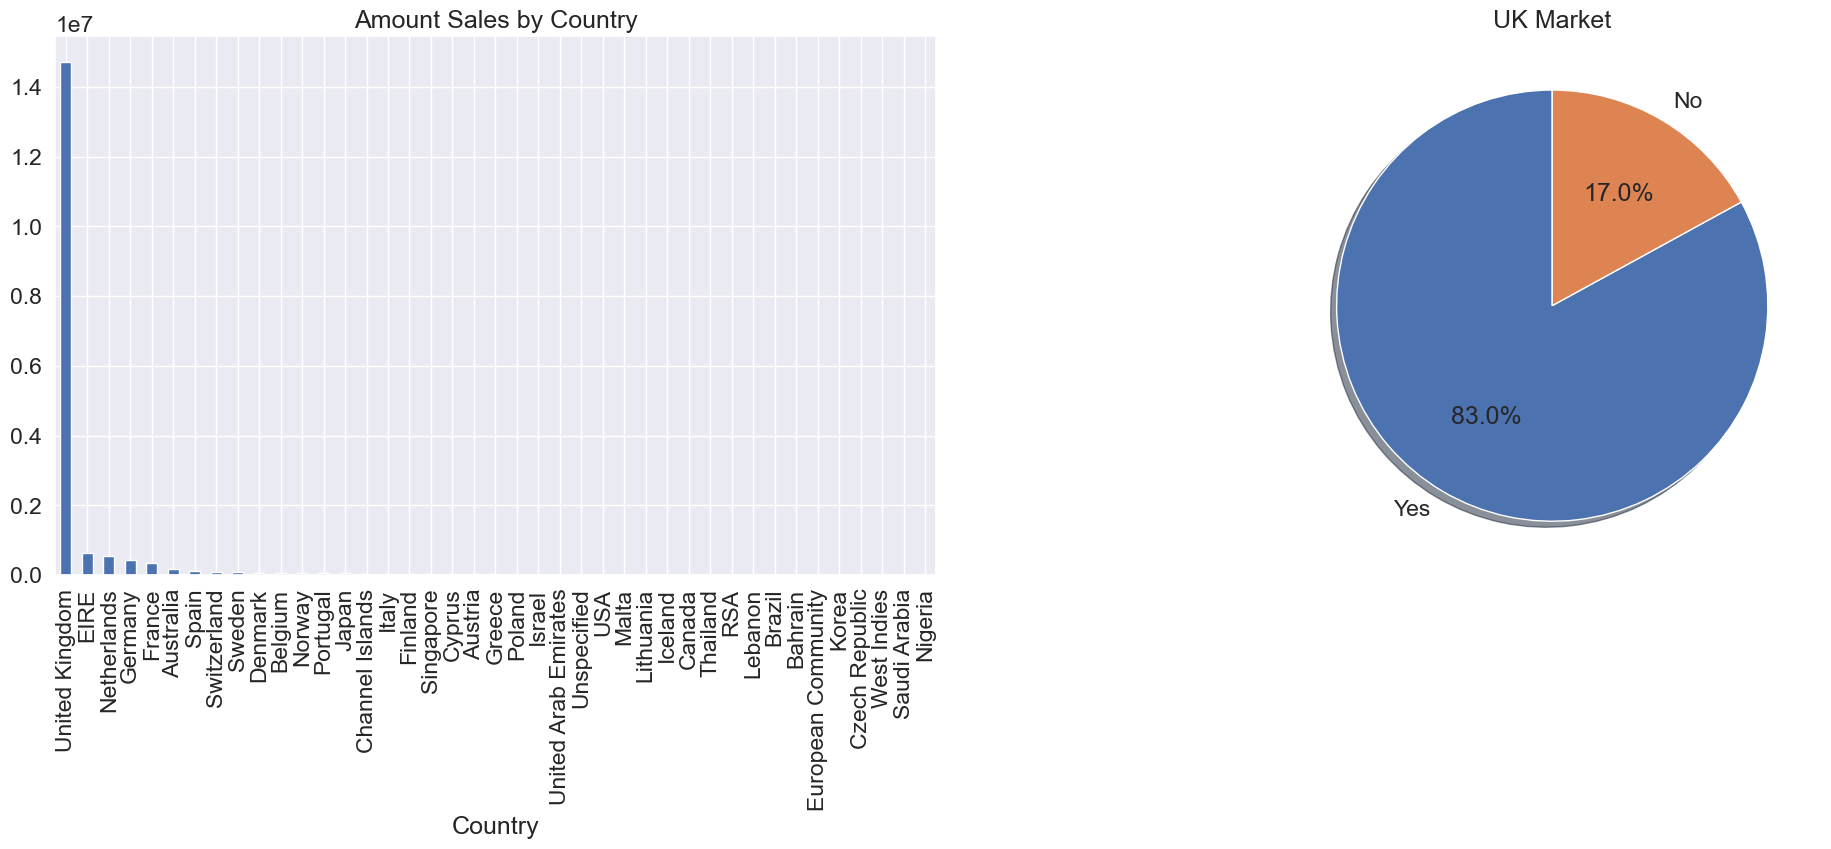

In [14]:
fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
g = cs_df.groupby(["Country"]).amount.sum().sort_values(ascending = False).plot(kind='bar', title='Amount Sales by Country')
cs_df['UK'] = cs_df.Country.apply(lambda x: 'Yes' if x=='United Kingdom' else 'No' )
f2 = fig.add_subplot(122)
market = cs_df.groupby(['UK']).amount.sum().sort_values(ascending = False)
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('UK Market')
plt.show()

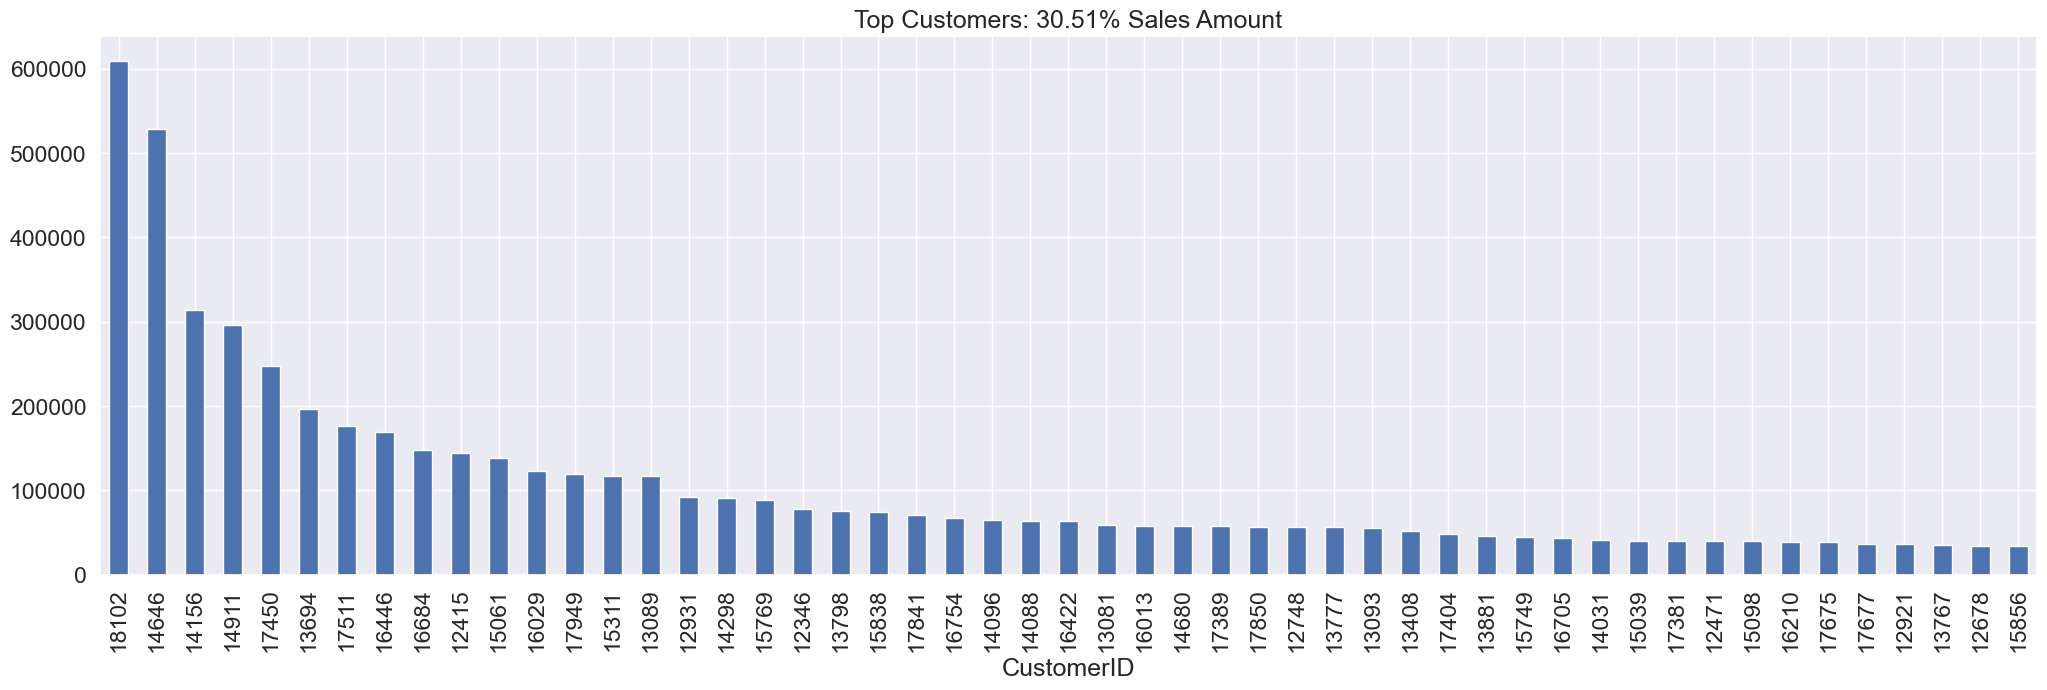

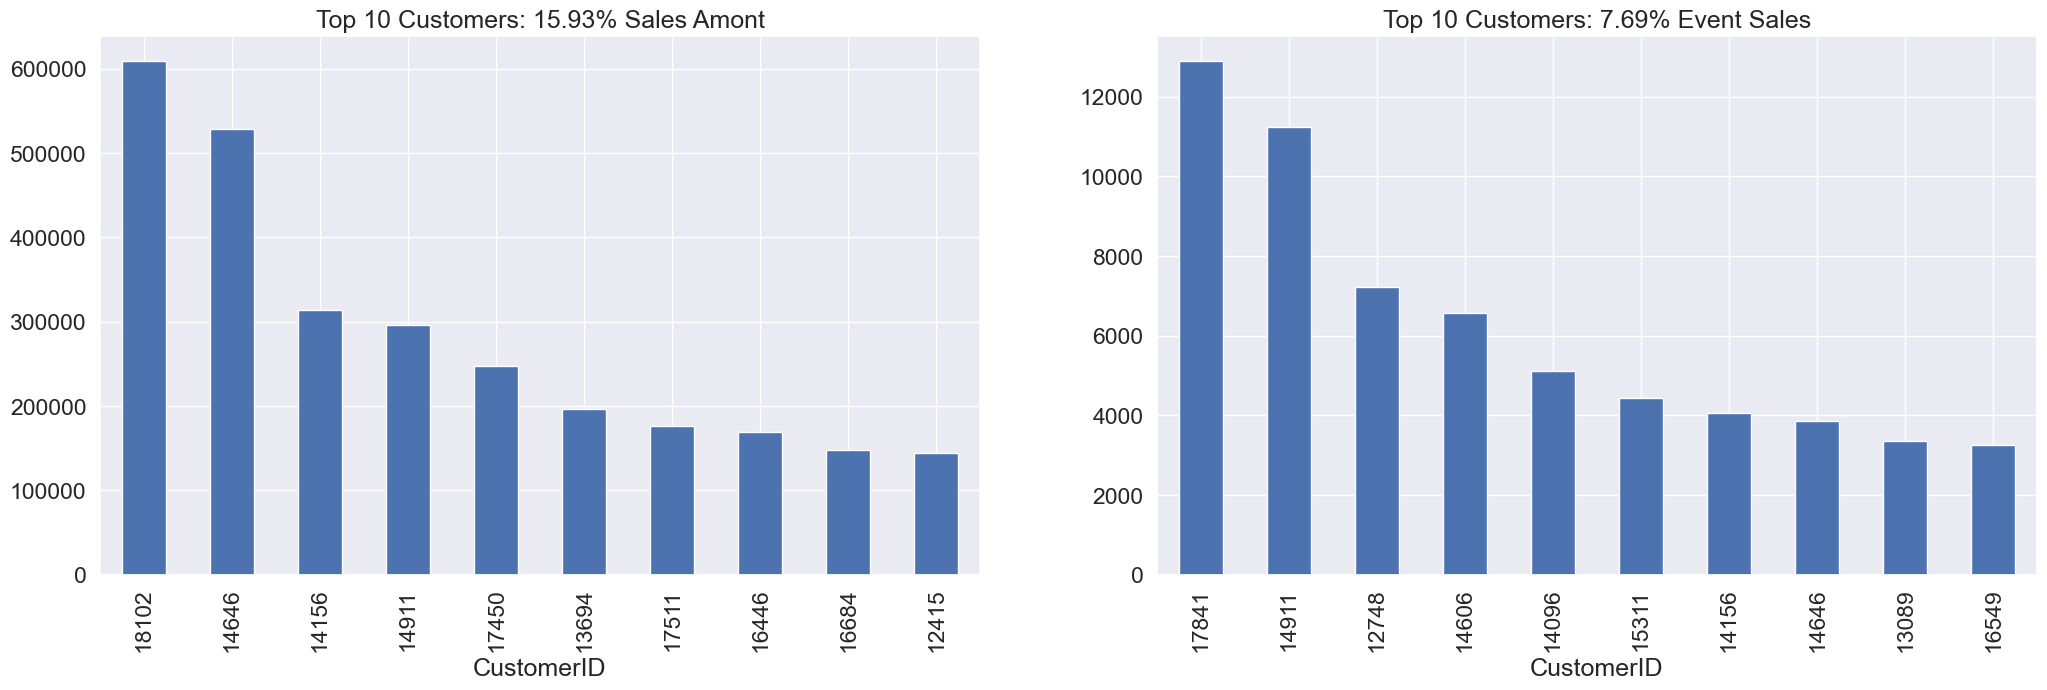

In [15]:
fig = plt.figure(figsize=(25, 7))
PercentSales =  np.round((cs_df.groupby(['CustomerID']).amount.sum().\
                          sort_values(ascending = False)[:51].sum()/cs_df.groupby(['CustomerID']).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(['CustomerID']).amount.sum().sort_values(ascending = False)[:51].\
    plot(kind='bar', title='Top Customers: {:3.2f}% Sales Amount'.format(PercentSales))

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
PercentSales =  np.round((cs_df.groupby(['CustomerID']).amount.sum().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(['CustomerID']).\
                          amount.sum().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(['CustomerID']).amount.sum().sort_values(ascending = False)[:10]\
    .plot(kind='bar', title='Top 10 Customers: {:3.2f}% Sales Amont'.format(PercentSales))
f1 = fig.add_subplot(122)
PercentSales =  np.round((cs_df.groupby(['CustomerID']).amount.count().\
                          sort_values(ascending = False)[:10].sum()/cs_df.groupby(['CustomerID']).\
                          amount.count().sort_values(ascending = False).sum()) * 100, 2)
g = cs_df.groupby(['CustomerID']).amount.count().sort_values(ascending = False)[:10].\
    plot(kind='bar', title='Top 10 Customers: {:3.2f}% Event Sales'.format(PercentSales))

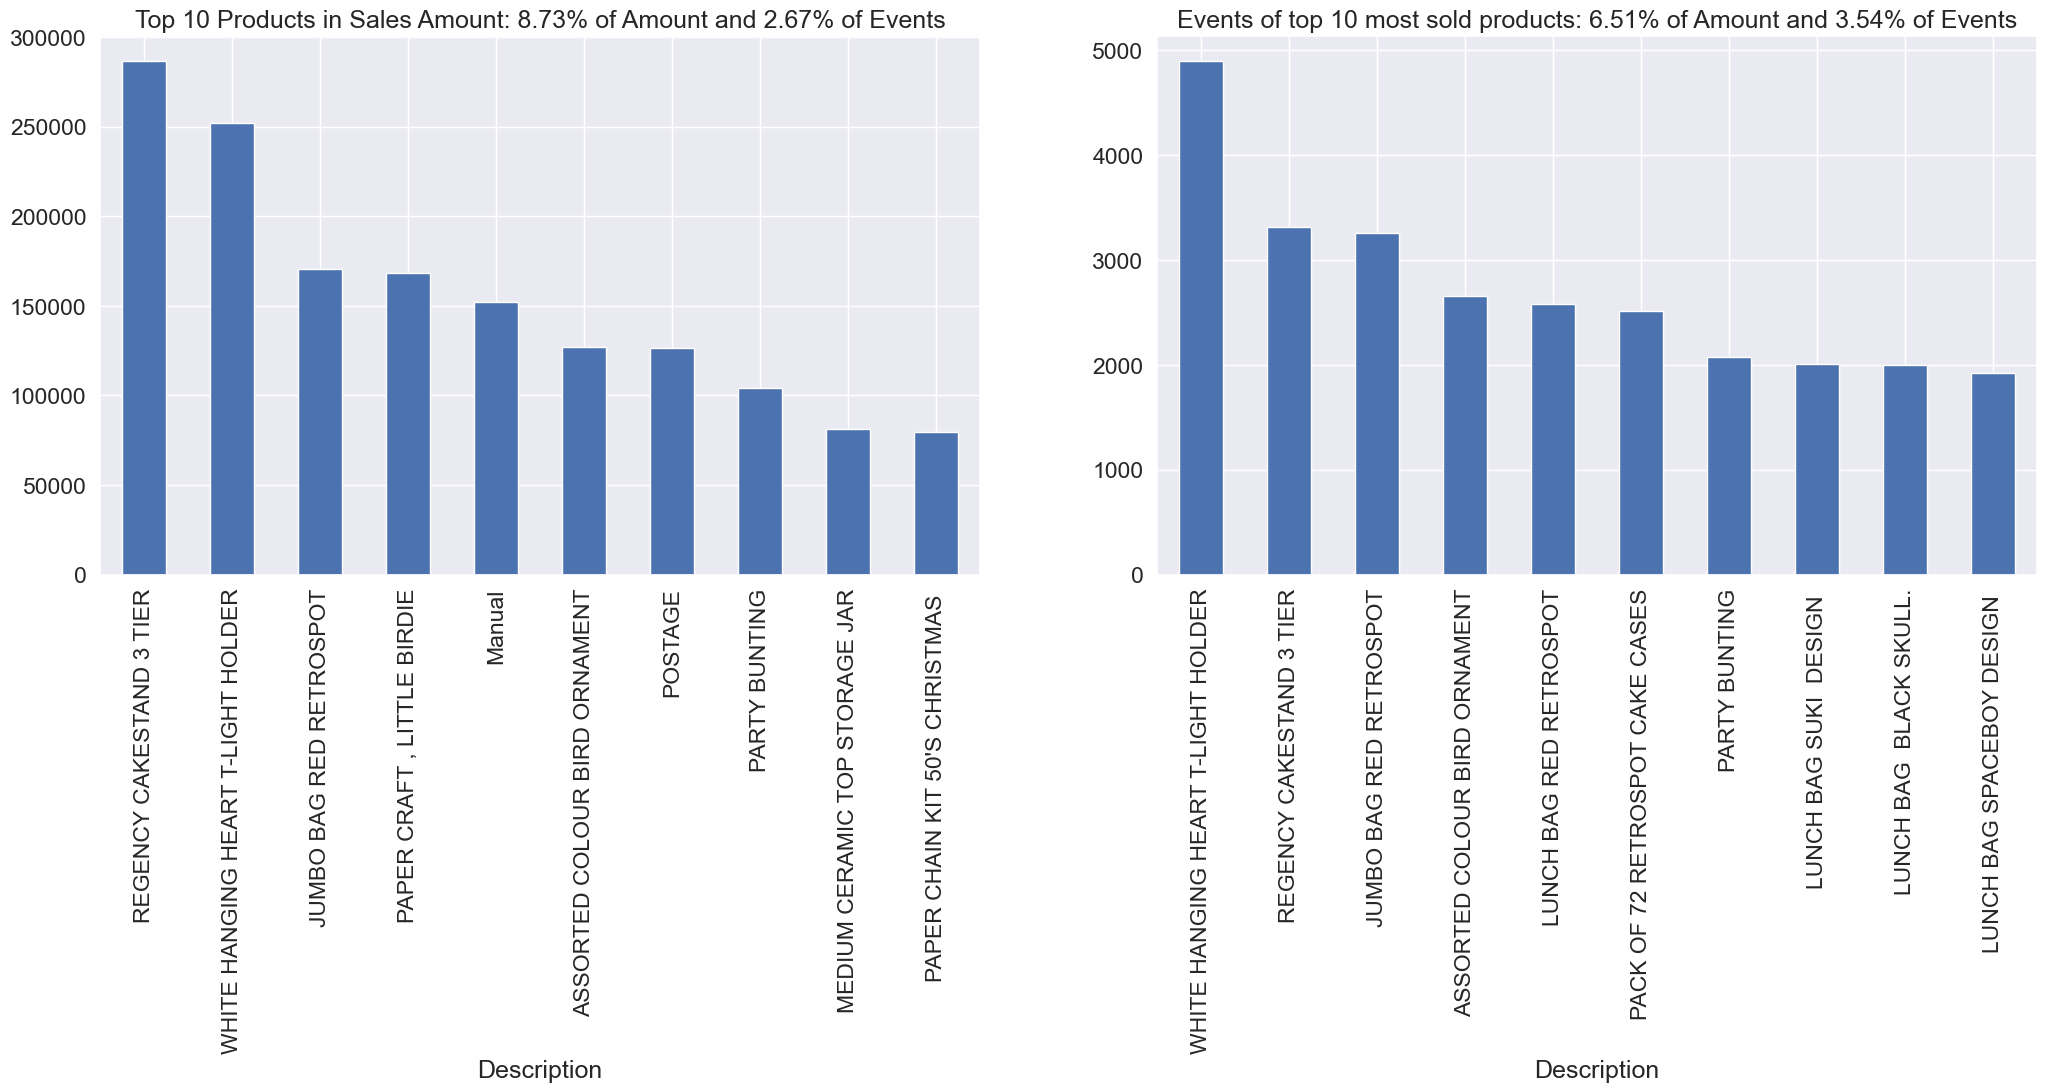

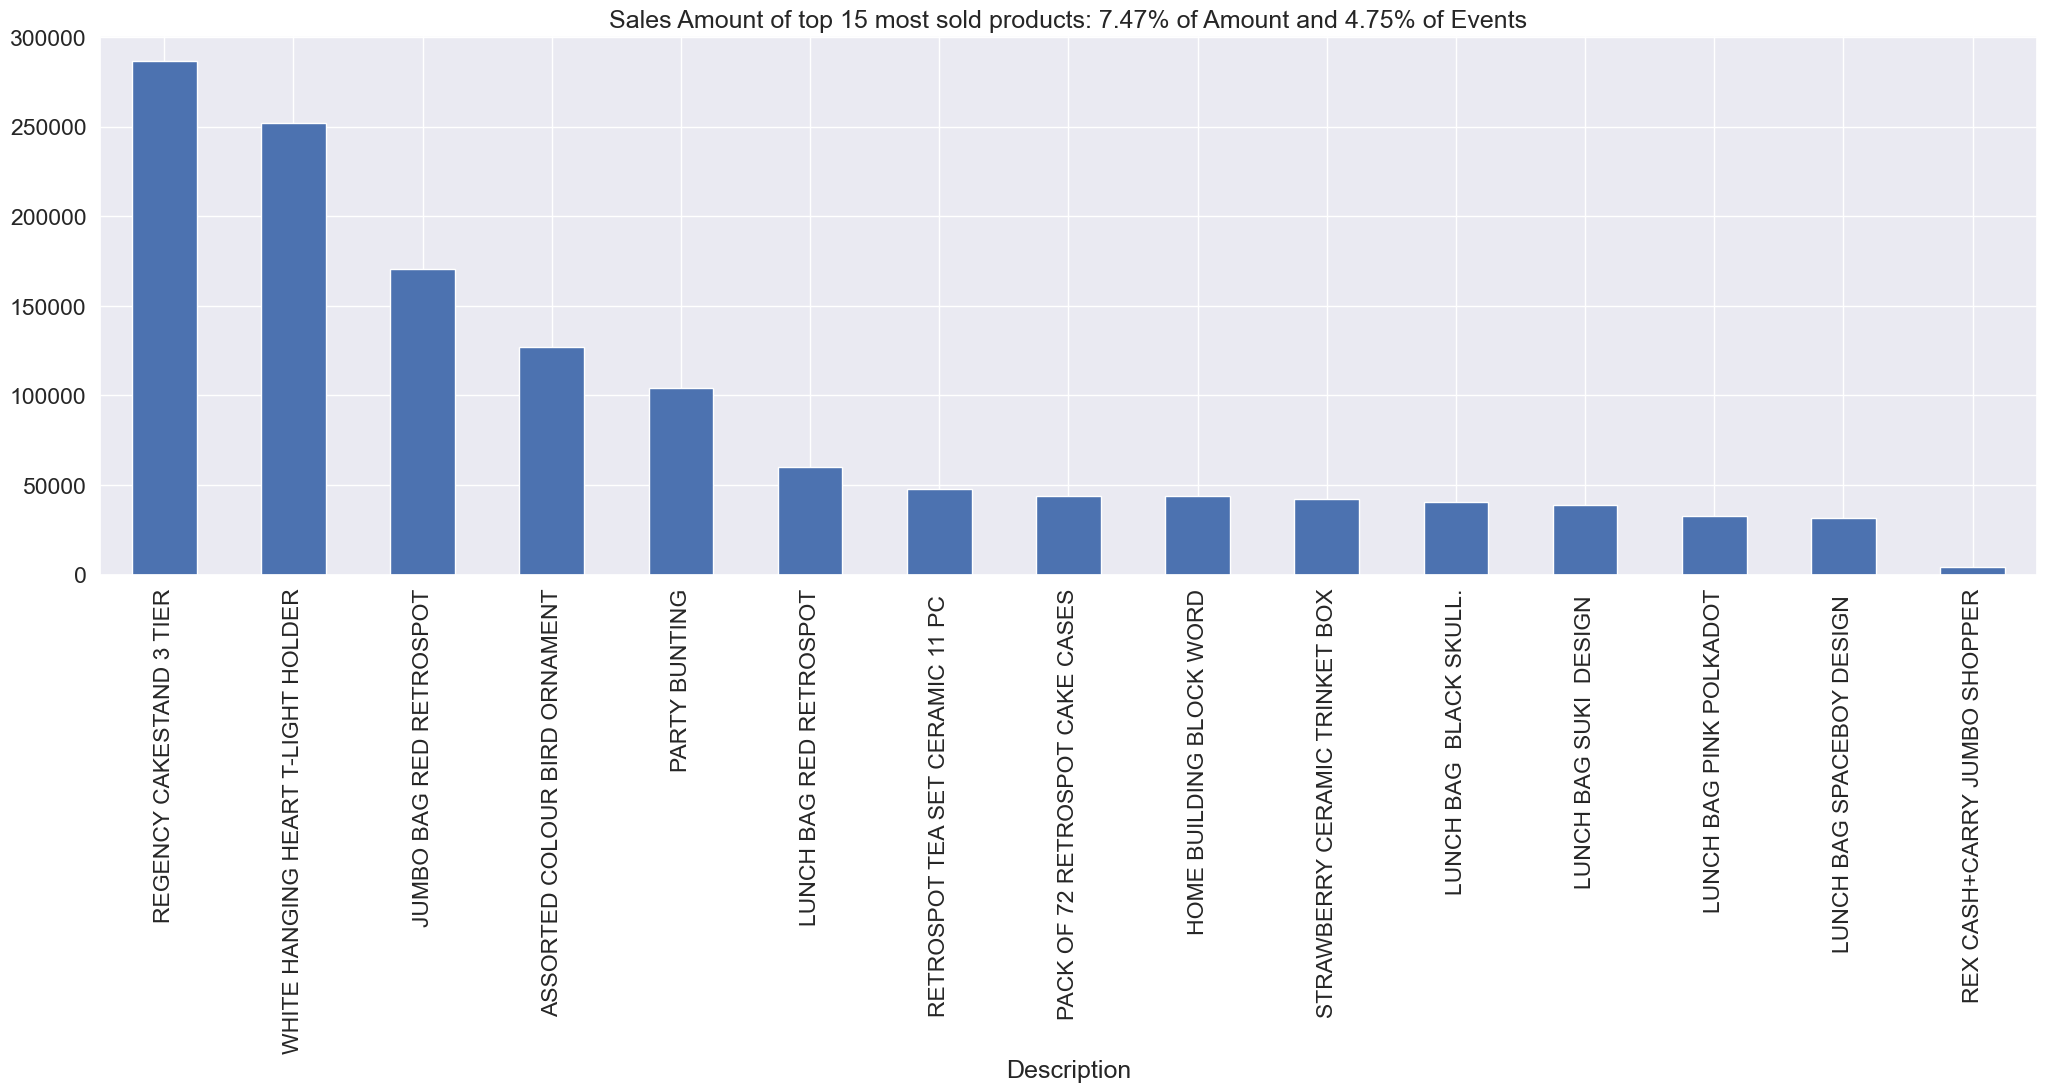

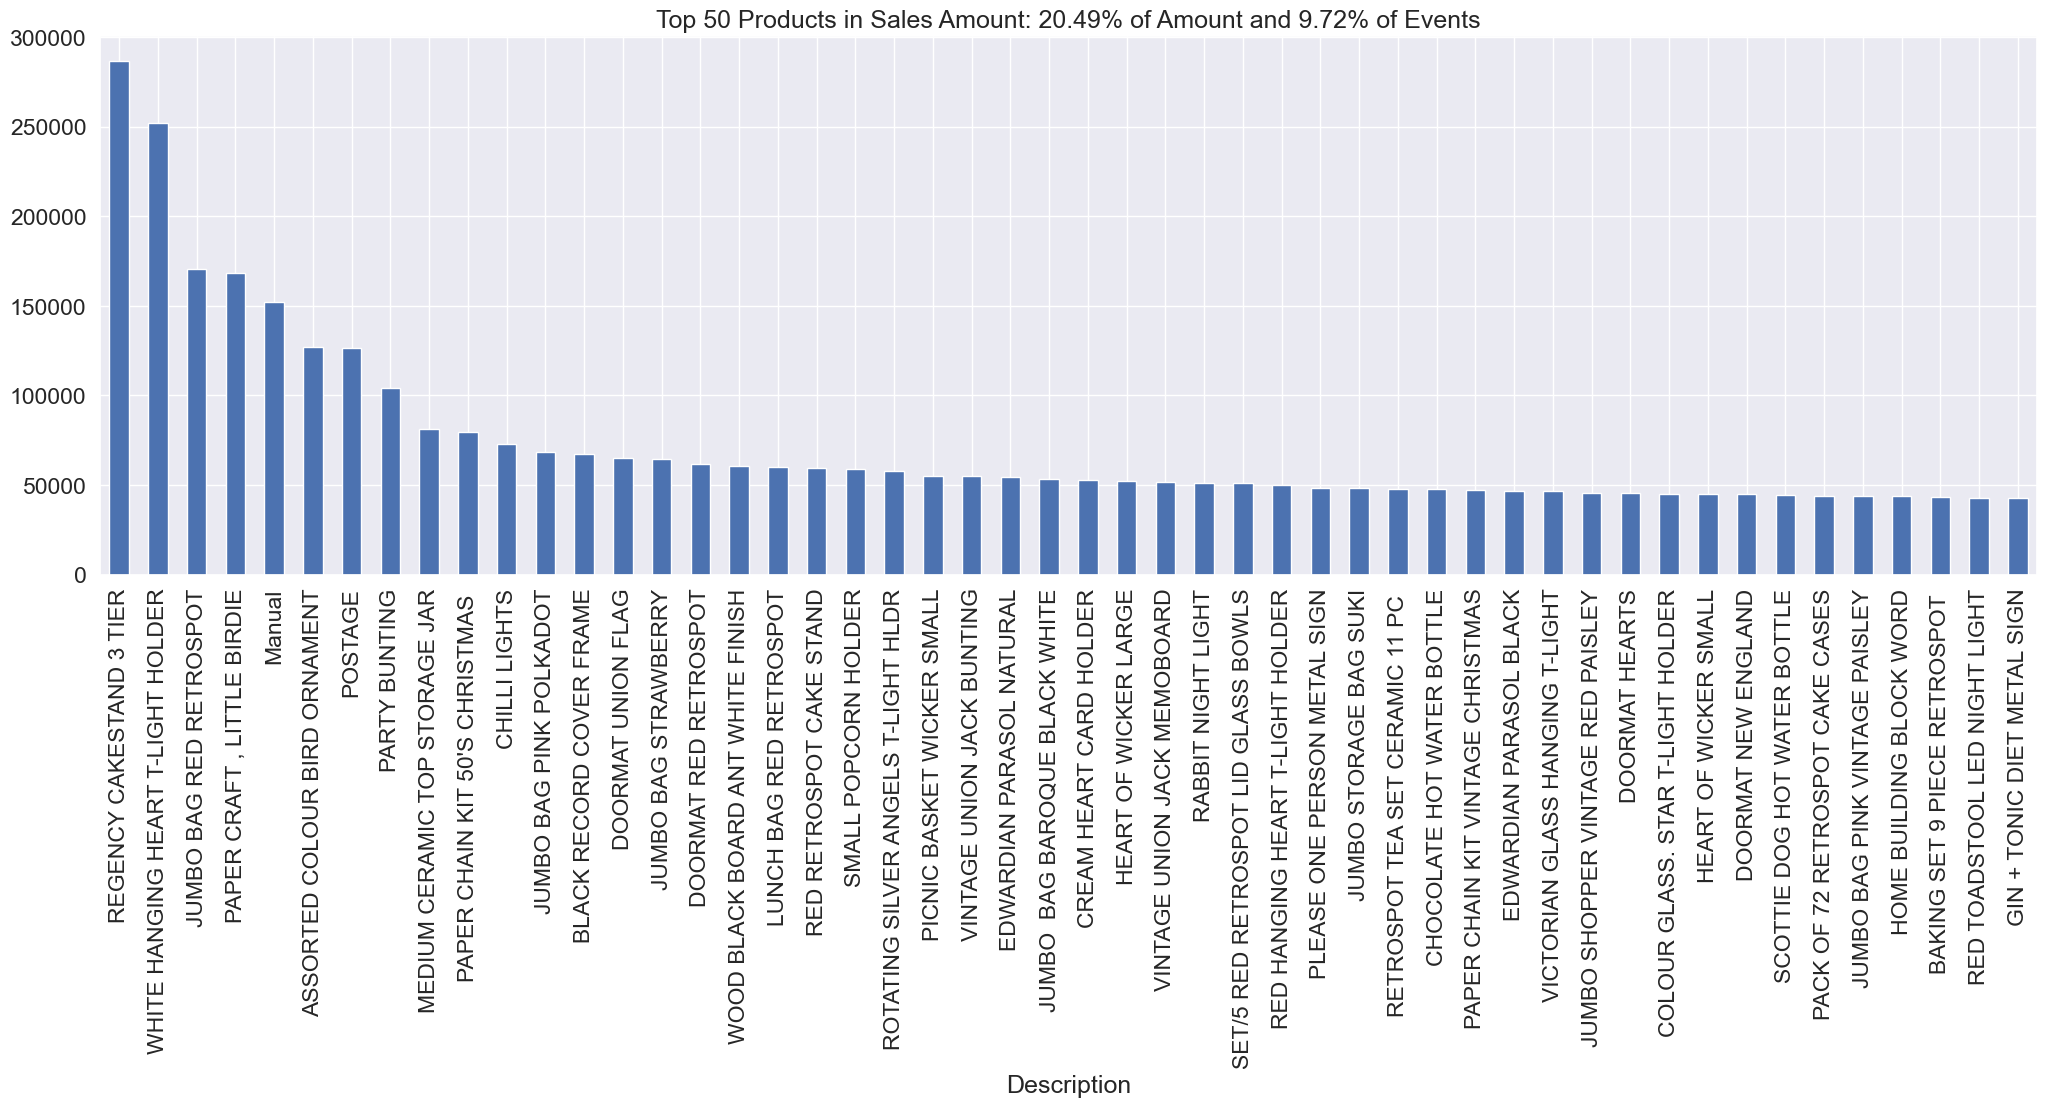

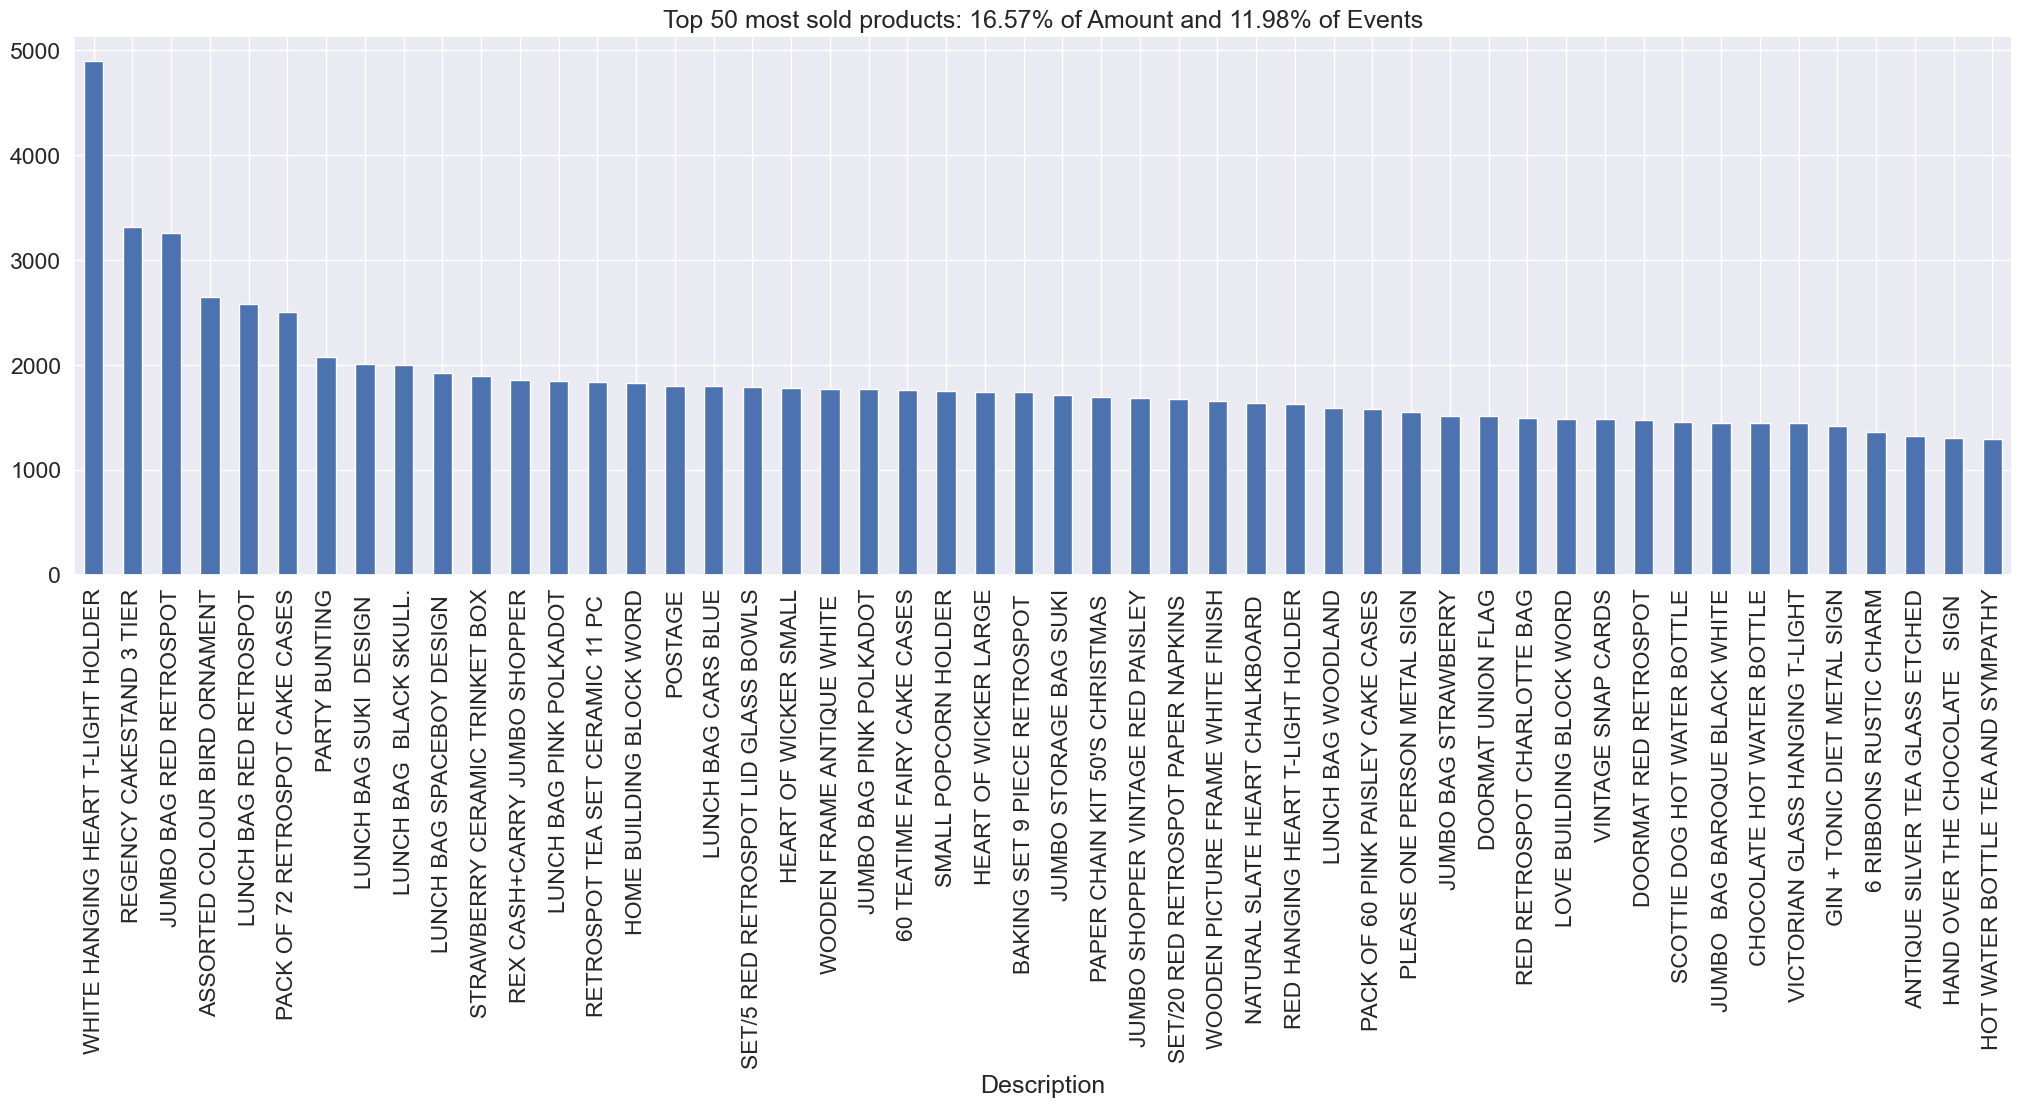

In [16]:
AmoutSum = cs_df.groupby(['Description']).amount.sum().sort_values(ascending = False)
inv = cs_df[['Description', 'Invoice']].groupby(['Description']).Invoice.unique().\
      agg(np.size).sort_values(ascending = False)

fig = plt.figure(figsize=(25, 7))
f1 = fig.add_subplot(121)
Top10 = list(AmoutSum[:10].index)
PercentSales =  np.round((AmoutSum[Top10].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top10].\
    plot(kind='bar', title='Top 10 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

f1 = fig.add_subplot(122)
Top10Ev = list(inv[:10].index)
PercentSales =  np.round((AmoutSum[Top10Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top10Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top10Ev].\
    plot(kind='bar', title='Events of top 10 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))


fig = plt.figure(figsize=(25, 7))
Top15ev = list(inv[:15].index)
PercentSales =  np.round((AmoutSum[Top15ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top15ev].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top15ev].sort_values(ascending = False).\
    plot(kind='bar', 
         title='Sales Amount of top 15 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50 = list(AmoutSum[:50].index)
PercentSales =  np.round((AmoutSum[Top50].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50].sum()/inv.sum()) * 100, 2)
g = AmoutSum[Top50].\
    plot(kind='bar', 
         title='Top 50 Products in Sales Amount: {:3.2f}% of Amount and {:3.2f}% of Events'.\
         format(PercentSales, PercentEvents))

fig = plt.figure(figsize=(25, 7))
Top50Ev = list(inv[:50].index)
PercentSales =  np.round((AmoutSum[Top50Ev].sum()/AmoutSum.sum()) * 100, 2)
PercentEvents = np.round((inv[Top50Ev].sum()/inv.sum()) * 100, 2)
g = inv[Top50Ev].\
    plot(kind='bar', title='Top 50 most sold products: {:3.2f}% of Amount and {:3.2f}% of Events'.\
                       format(PercentSales, PercentEvents))

## Customer Segmentation:
Customer segmentation is similarly the process of dividing an organization’s customer bases into different sections or segments based on various customer attributes.  The process of customer segmentation is based on the premise of finding differences among the customers’ behavior and patterns.

The major objectives and benefits behind the motivation for customer segmentation are:
* **Higher Revenue**: This is the most obvious requirement of any customer segmentation project. 
* **Customer Understanding**: One of the mostly widely accepted business paradigms is “know your customer” and a segmentation of the customer base allows for a perfect dissection of this paradigm. 
* **Target Marketing**:  The most visible reason for customer segmentation is the ability to focus marketing efforts effectively and efficiently. If a firm knows the different segments of its customer base, it can devise better marketing campaigns which are tailor made for the segment. A good segmentation model allows for better understanding of customer requirements and hence increases the chances of the success of any marketing campaign developed by the organization.
* **Optimal Product Placement**: A good customer segmentation strategy can also help the firm with developing or offering new products, or a bundle of products together as a combined offering.
* **Finding Latent Customer Segments**: Finding out which segment of customers it might be missing to identifying untapped customer segments by focused on marketing campaigns or new business development.

**Clustering**:

The most obvious method to perform customer segmentation is using unsupervised Machine Learning methods like clustering.  The method is as simple as collecting as much data about the customers as possible in the form of features or attributes and then finding out the different clusters that can be obtained from that data. Finally, we can find traits of customer segments by analyzing the characteristics of the clusters.

**Exploratory Data Analysis**:

Using exploratory data analysis is another way of finding out customer segments. This is usually done by analysts who have a good knowledge about the domain relevant to both products and customers. It can be done flexibly to include the top decision points in an analysis. 
 
### RFM Model for Customer Value:

Since our dataset is limited to the sales records, and didn´t include anothers information about our customers, we will use a **RFM**,***Recency, Frequency and Monetary Value**, based model of customer value for finding our customer segments.
 The RFM model will take the transactions of a customer and calculate three important informational attributes about each customer:
- **Recency**: The value of how recently a customer purchased at the establishment
- **Frequency**: How frequent the customer’s transactions are at the establishment
- **Monetary value**: The dollar (or pounds in our case) value of all the transactions that the customer made at the establishment

#### Recency
To create the recency feature variable, we need to decide the reference date for our analysis. Usually, we make use of the last transaction date plus one day. Then, we will construct the recency variable as the number of days before the reference date when a customer last made a purchase.

In [17]:
refrence_date = cs_df.InvoiceDate.max() + datetime.timedelta(days = 1)
print('Reference Date:', refrence_date)
cs_df['days_since_last_purchase'] = (refrence_date - cs_df.InvoiceDate).astype('timedelta64[D]')
customer_history_df =  cs_df[['CustomerID', 'days_since_last_purchase']].groupby("CustomerID").min().reset_index()
customer_history_df.rename(columns={'days_since_last_purchase':'recency'}, inplace=True)
customer_history_df.describe().transpose()

Reference Date: 2011-12-10 12:50:00


count          mean          std      min       25%      50%  \
CustomerID  5878.0  15315.313542  1715.572666  12346.0  13833.25  15314.5   
recency     5878.0    201.331916   209.338707      1.0     26.00     96.0   

                 75%      max  
CustomerID  16797.75  18287.0  
recency       380.00    739.0

We will plot the Recency Distribution and QQ-plot to identify substantive departures from normality, likes outliers, skewness and kurtosis.

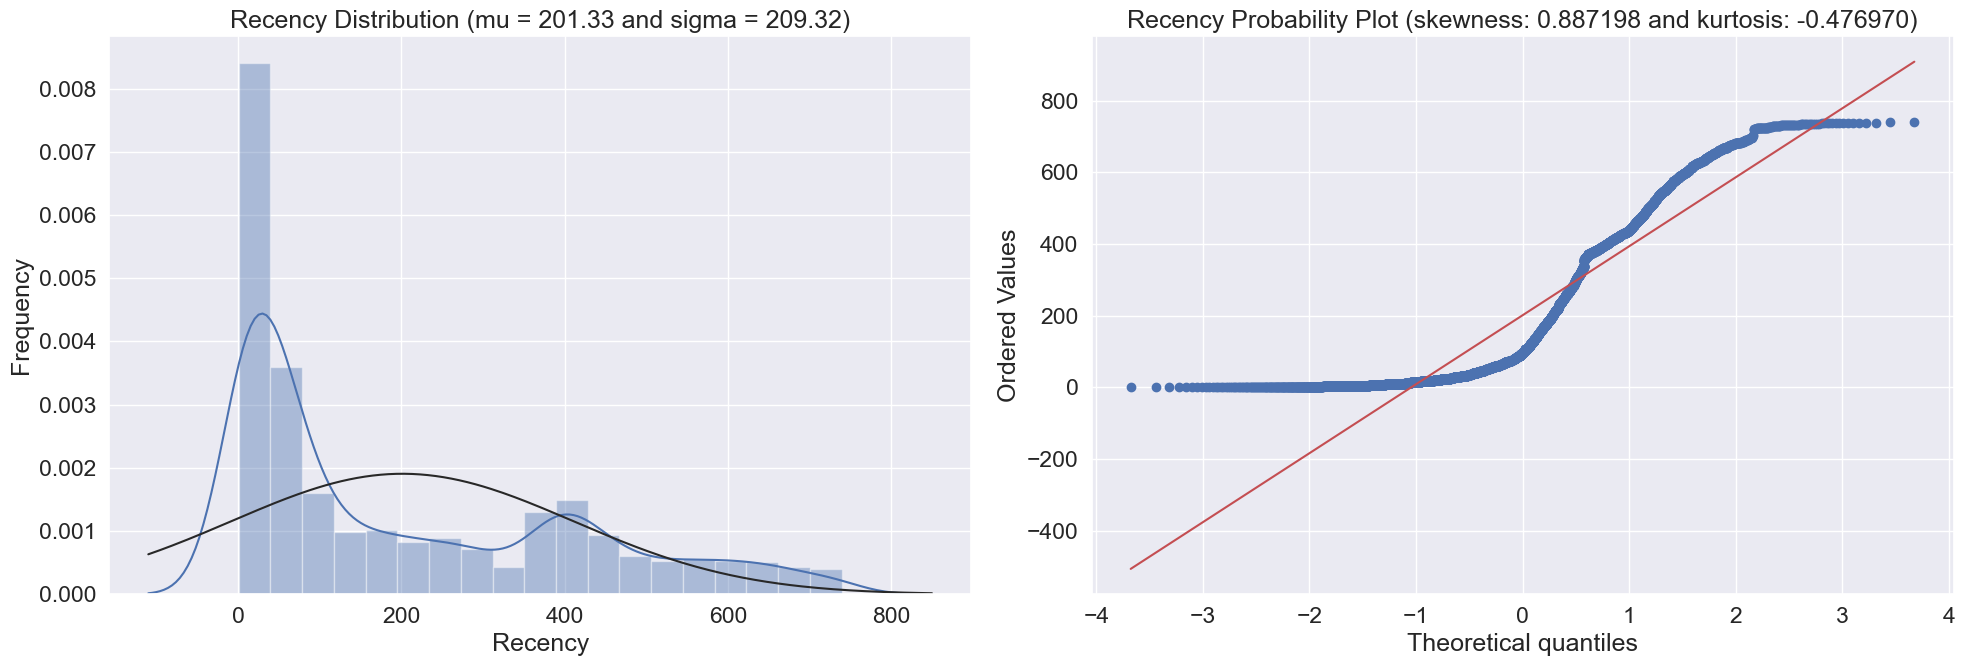

In [18]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(20,7))

    #Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(data)

    #Kernel Density plot
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)
    fig1.set_title(measure + ' Distribution (mu = {:.2f} and sigma = {:.2f})'.format(mu, sigma), loc='center')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    #QQ plot
    fig2 = fig.add_subplot(122)
    res = probplot(data, plot=fig2)
    fig2.set_title(measure + ' Probability Plot (skewness: {:.6f} and kurtosis: {:.6f})'.format(data.skew(), data.kurt()), loc='center')

    plt.tight_layout()
    plt.show()

QQ_plot(customer_history_df.recency, 'Recency')

From the first graph above we can see that sales recency distribution is ***skewed***, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

From the Probability Plot, we could see that sales recency does **not align with the diagonal  <span style="color:red">red line</span>** which represent normal distribution. The form of its distribution confirm that is a skewed right and light-tailed. 

With ***skewness positive of 0.89***, we confirm the lack of symmetry and indicate that sales recency are **skewed right**, as we can see too at the Sales Distribution plot, skewed right means that the right tail is long relative to the left tail. The skewness for a normal distribution is zero, and any symmetric data should have a skewness near zero. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point.

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. That is, data sets with high kurtosis tend to have heavy tails, or outliers, and positive kurtosis indicates a heavy-tailed distribution and negative kurtosis indicates a light tailed distribution. So, with **-0.48 of negative kurtosis** sales recency is **light-tailed**.

#### Frequency

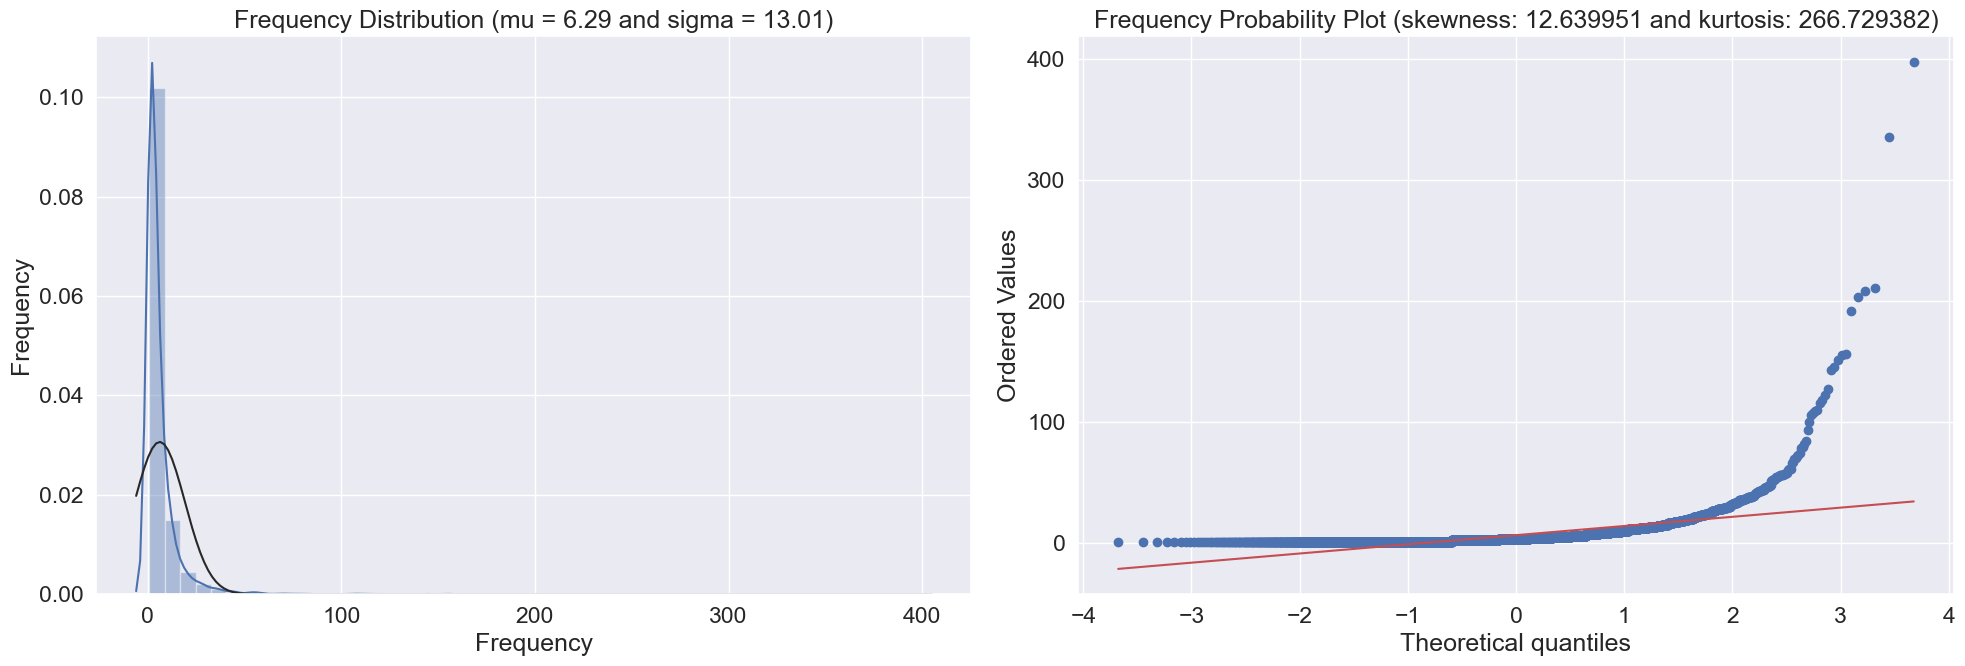

In [19]:
customer_freq = (cs_df[['CustomerID', 'Invoice']].groupby(["CustomerID", 'Invoice']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
customer_freq.rename(columns={'Invoice':'frequency'},inplace=True)
customer_history_df = customer_history_df.merge(customer_freq)
QQ_plot(customer_history_df.frequency, 'Frequency')

From the first graph above we can see that sales frequency distribution is ***skewed***, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

From the Probability Plot, we could see that sales frequency also does **not align with the diagonal** and confirm that is a **skewed right**.

With ***skewness positive of 12.6***, we confirm the extremely high lack of symmetry and with **266.7 Kurtosis** indicates that is a **heavy-tailed distribution** and has **outliers**.

#### Monetary Value

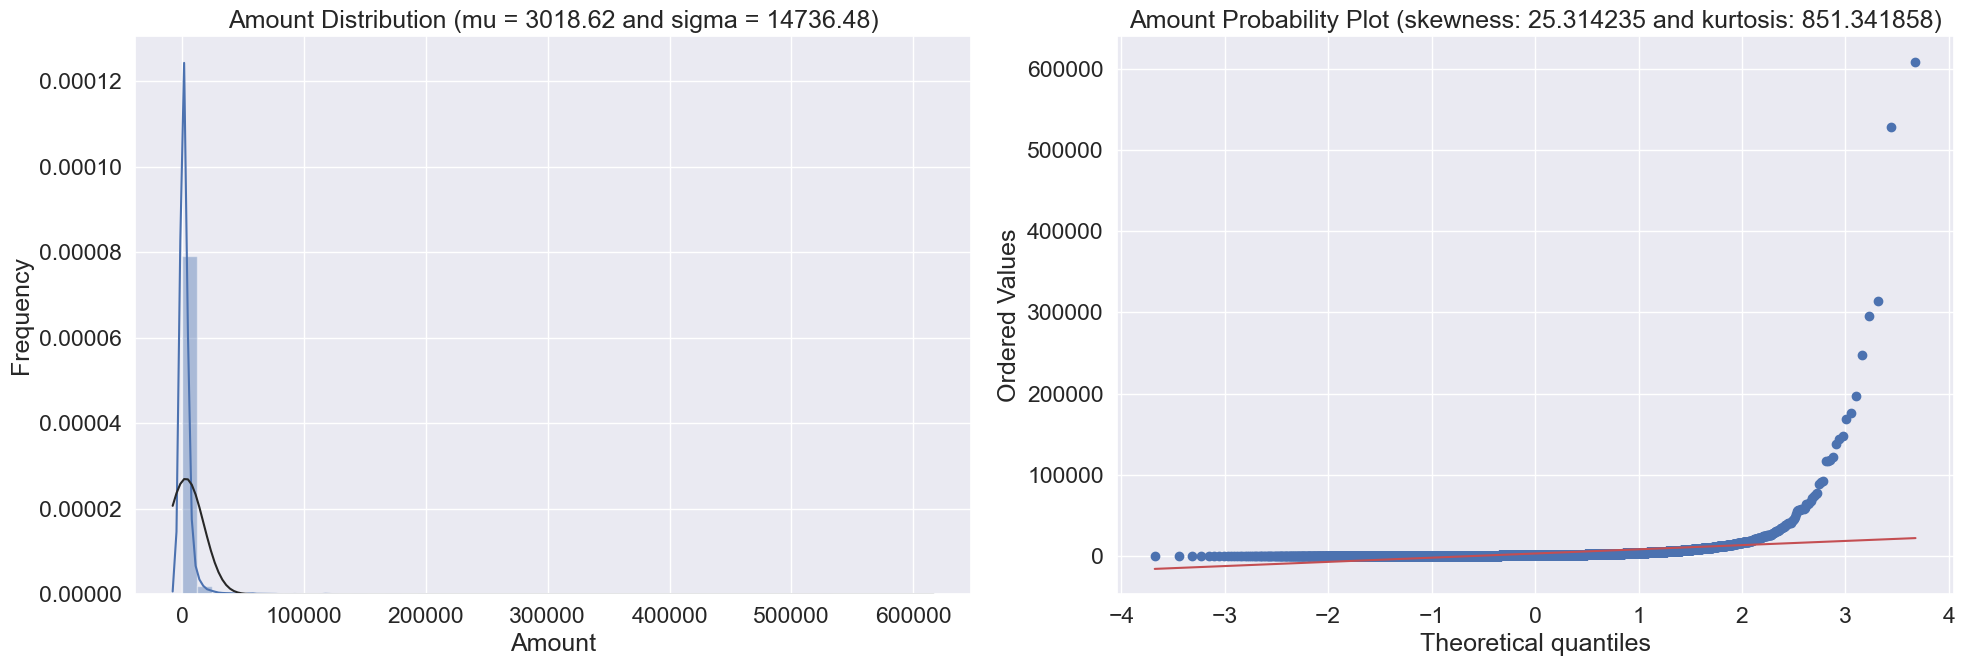

In [20]:
customer_monetary_val = cs_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
customer_history_df = customer_history_df.merge(customer_monetary_val)
QQ_plot(customer_history_df.amount, 'Amount')

From the first graph above we can see that sales amount distribution is ***skewed***, has a peak on the left and a long tail to the right. It deviates from normal distribution and is positively biased.

From the Probability Plot, we could see that sales amount also does **not align with the diagonal**, special on the right. 

With ***skewness positive of 25.3***, we confirm the **high lack of symmetry** and with **851.3 Kurtosis** indicates that is a **too heavy-tailed distribution** and has **outliers**, surely more than 10 very extreme.

Let's see a statistical summary of this dataset:

In [21]:
customer_history_df.describe()

CustomerID      recency    frequency         amount
count   5878.000000  5878.000000  5878.000000    5878.000000
mean   15315.313542   201.331916     6.289384    3018.616737
std     1715.572666   209.338707    13.009406   14737.731040
min    12346.000000     1.000000     1.000000       2.950000
25%    13833.250000    26.000000     1.000000     348.762500
50%    15314.500000    96.000000     3.000000     898.915000
75%    16797.750000   380.000000     7.000000    2307.090000
max    18287.000000   739.000000   398.000000  608821.650000

### Data Preprocessing
Once we have created our customer value dataset, we will perform some preprocessing on the data. For our clustering, we will be using the *K-means* clustering algorithm. One of the requirements for proper functioning of the algorithm is the mean centering of the variable values. Mean centering of a variable value means that we will replace the actual value of the variable with a standardized value, so that the variable has a mean of 0 and variance of 1. This ensures that all the variables are in the same range and the difference in ranges of values doesn't cause the algorithm to not perform well. This is akin to feature scaling.

Another problem that you can investigate about is the huge range of values each variable can take. This
problem is particularly noticeable for the monetary amount variable. To take care of this problem, we will transform all the variables on the log scale. This transformation, along with the standardization, will ensure that the input to our algorithm is a homogenous set of scaled and transformed values.

An important point about the data preprocessing step is that sometimes we need it to be reversible. In our case, we will have the clustering results in terms of the log transformed and scaled variable. But to make inferences in terms of the original data, we will need to reverse transform all the variable so that we get back the actual RFM figures. This can be done by using the preprocessing capabilities of Python.

In [22]:
customer_history_df['recency_log'] = customer_history_df['recency'].apply(math.log)
customer_history_df['frequency_log'] = customer_history_df['frequency'].apply(math.log)
customer_history_df['amount_log'] = customer_history_df['amount'].apply(math.log)
feature_vector = ['amount_log', 'recency_log','frequency_log']
X_subset = customer_history_df[feature_vector] #.as_matrix()
scaler = preprocessing.StandardScaler().fit(X_subset)
X_scaled = scaler.transform(X_subset)
pd.DataFrame(X_scaled, columns=X_subset.columns).describe().T

count          mean       std       min       25%       50%  \
amount_log     5878.0  2.621622e-16  1.000085 -4.133845 -0.703906 -0.023467   
recency_log    5878.0  1.030611e-16  1.000085 -2.693508 -0.702175  0.096200   
frequency_log  5878.0  1.834758e-16  1.000085 -1.168894 -1.168894 -0.100752   

                    75%       max  
amount_log     0.653923  4.660923  
recency_log    0.937097  1.343619  
frequency_log  0.723045  4.651521

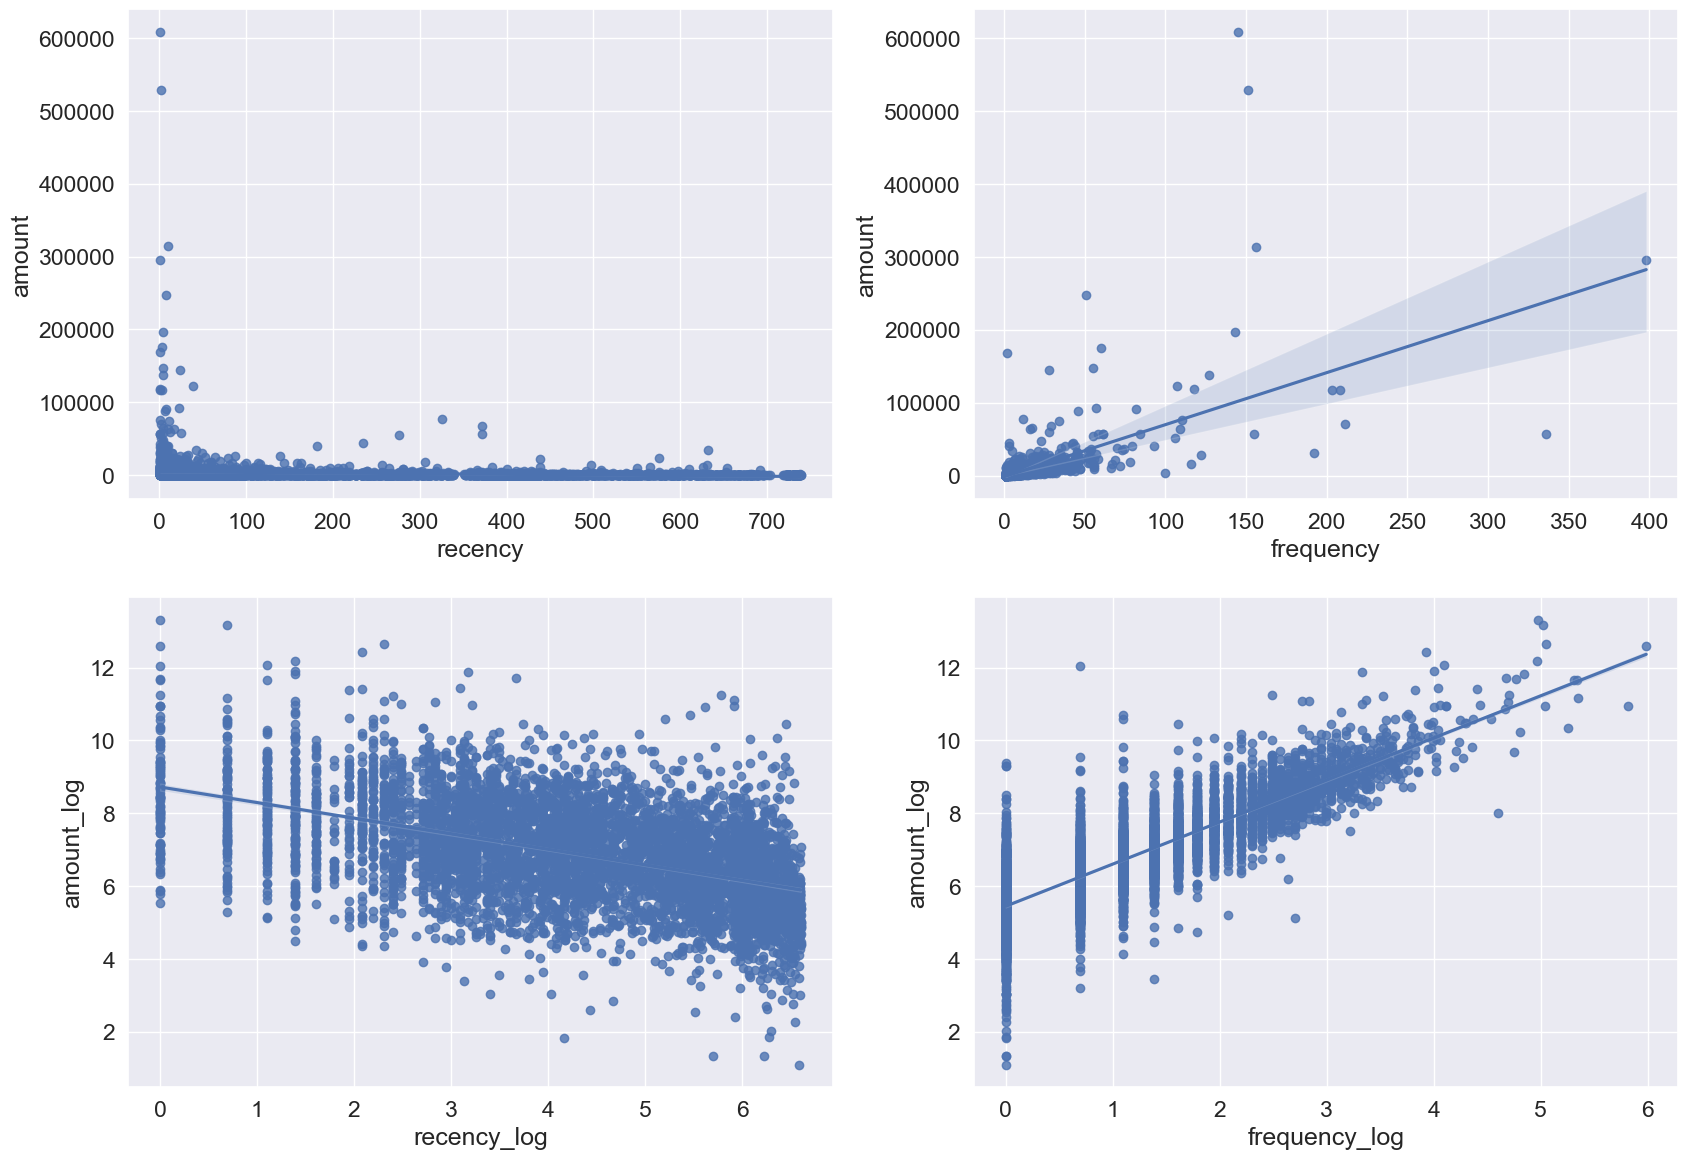

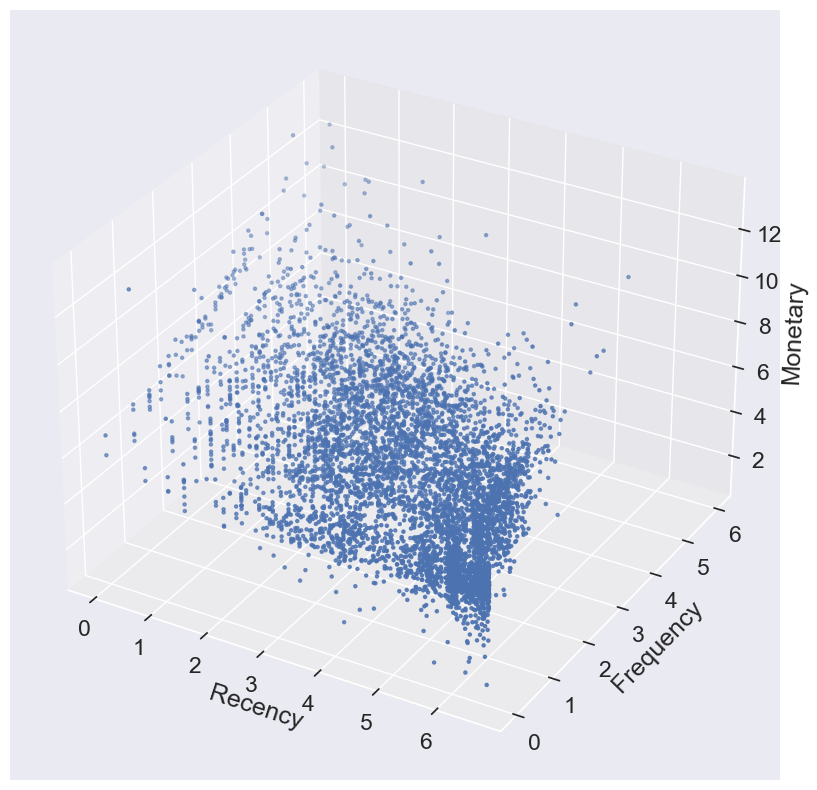

In [23]:
fig = plt.figure(figsize=(20,14))
f1 = fig.add_subplot(221); sns.regplot(x='recency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(222); sns.regplot(x='frequency', y='amount', data=customer_history_df)
f1 = fig.add_subplot(223); sns.regplot(x='recency_log', y='amount_log', data=customer_history_df)
f1 = fig.add_subplot(224); sns.regplot(x='frequency_log', y='amount_log', data=customer_history_df)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs =customer_history_df.recency_log
ys = customer_history_df.frequency_log
zs = customer_history_df.amount_log
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

plt.show()

The obvious patterns we can see from the plots above is that costumers who buy with a higher frequency and more recency tend to spend more based on the increasing trend in Monetary (amount value) with a corresponding increasing and decreasing trend for Frequency and Recency, respectively. 

### Clustering for Segments
#### *K-Means* Clustering
The *K-means* clustering belongs to the partition based\centroid based hard clustering family of algorithms, a family of algorithms where each sample in a dataset is assigned to exactly one cluster.

Based on this Euclidean distance metric, we can describe the *K-means* algorithm as a simple optimization problem, an iterative approach for minimizing the within-cluster sum of squared errors (SSE), which is sometimes also called cluster inertia. So, the objective of *K-means* clustering is to minimize total intra-cluster variance, or, the squared error function:
$$
J=\sum^k_{j=1}\sum^n_{i=1}||x_i^{(j)}-c_j||^2
$$
The steps that happen in the *K-means* algorithm for partitioning the data are as given follows:
1. The algorithm starts with random point initializations of the required number of centers. The “K” in *K-means* stands for the number of clusters.
2. In the next step, each of the data point is assigned to the center closest to it. The distance metric used in *K-means* clustering is normal Euclidian distance.
3. Once the data points are assigned, the centers are recalculated by averaging the dimensions of the points belonging to the cluster.
4. The process is repeated with new centers until we reach a point where the assignments become stable. In this case, the algorithm terminates.

#### *K-means++*
- Place the initial centroids far away from each other via the *K-means++* algorithm, which leads to better and more consistent results than the classic *K-means*.
- To use *K-means++* with scikit-learn's KMeans object, we just need to set the init parameter to *K-means++* (the default setting) instead of random.

#### The Elbow Method
  
Using the elbow method to find the optimal number of clusters. The idea behind the elbow method is to identify the value of *k* where the distortion begins to increase most rapidly. If *k* increases, the distortion will decrease, because the samples will be closer to the centroids they are assigned to. 

This method looks at the percentage of variance explained as a function of the number of clusters. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified.Percentage of variance explained is the ratio of the between-group variance to the total variance, also known as an F-test. A slight variation of this method plots the curvature of the within group variance.

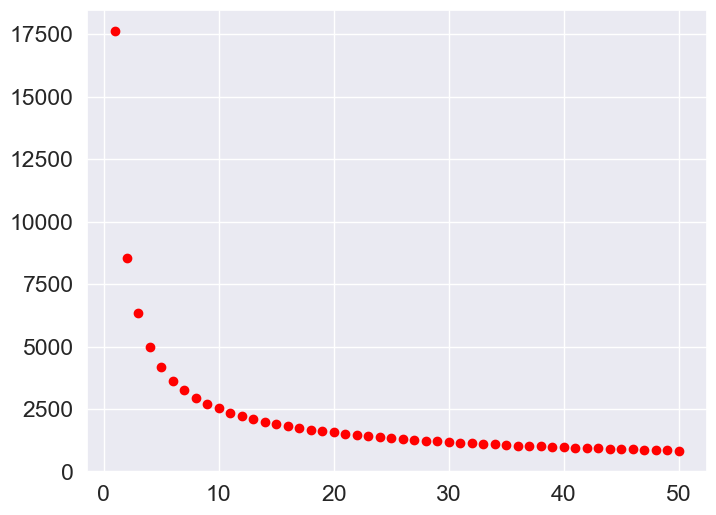

The best K sugest:  7


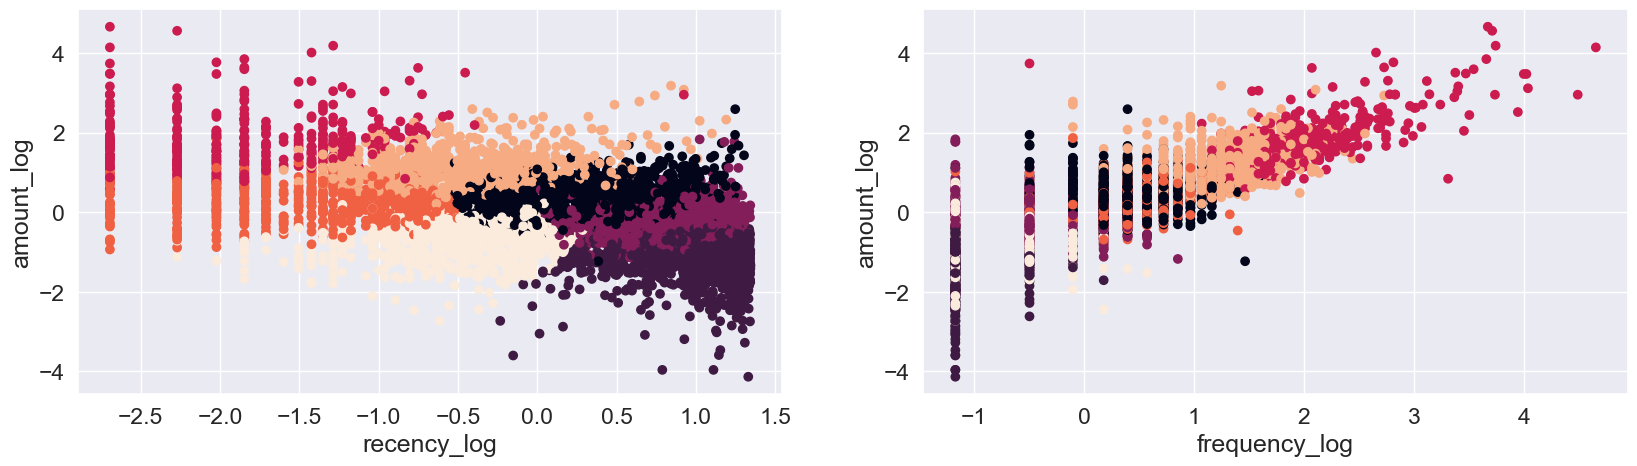

In [24]:
cl = 50
corte = 0.1

anterior = 100000000000000
cost = [] 
K_best = cl

for k in range (1, cl+1):
    # Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
    model = KMeans(
        n_clusters=k, 
        init='k-means++', #'random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=101)

    model = model.fit(X_scaled)

    # These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
    labels = model.labels_
 
    # Sum of distances of samples to their closest cluster center
    interia = model.inertia_
    if (K_best == cl) and (((anterior - interia)/anterior) < corte): K_best = k - 1
    cost.append(interia)
    anterior = interia

plt.figure(figsize=(8, 6))
plt.scatter(range (1, cl+1), cost, c='red')
plt.show()

# Create a kmeans model with the best K.
print('The best K sugest: ',K_best)
model = KMeans(n_clusters=K_best, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)

# Note I'm scaling the data to normalize it! Important for good results.
model = model.fit(X_scaled)

# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
labels = model.labels_

# And we'll visualize it:
#plt.scatter(X_scaled[:,0], X_scaled[:,1], c=model.labels_.astype(float))
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(121)
plt.scatter(x = X_scaled[:,1], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[1])
ax.set_ylabel(feature_vector[0])
ax = fig.add_subplot(122)
plt.scatter(x = X_scaled[:,2], y = X_scaled[:,0], c=model.labels_.astype(float))
ax.set_xlabel(feature_vector[2])
ax.set_ylabel(feature_vector[0])

plt.show()

Note that by the Elbow method from a K equal to 3 we already observed low rates of gain in the decay of the distortions with the decrease of K reaching the limit of 10% with the K equal to 7. With this in mind, we will begin to evaluate the options more deeply with 3, and 7, starting with the silhouette analysis.

#### Silhouette analysis on K-Means clustering

Silhouette analysis can be used to study the separation distance between the resulting clusters, as a strategy to quantifying the quality of clustering via graphical tool to plot a measure of how tightly grouped the samples in the clusters are. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. 

It can also be applied to clustering algorithms other than k-means

Silhouette coefficients has a range of \[-1, 1\], it calculated by:
1. Calculate the cluster cohesion a(i) as the average distance between a sample x(i) and all other points in the same cluster.
2. Calculate the cluster separation b(i) from the next closest cluster as the average distance between the sample x(i) and all samples in the nearest cluster.
3. Calculate the silhouette s(i) as the difference between cluster cohesion and separation divided by the greater of the two.

Where:
- If near +1, it indicate that the sample is far away from the neighboring clusters. 
- a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. 
- If most objects have a high value, then the clustering configuration is appropriate. 
- If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.
- A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters
- Negative values indicate that those samples might have been assigned to the wrong cluster.

The silhouette plot can shows a bad K clusters pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. A good k clusters can found when all the plots are more or less of similar thickness and hence are of similar sizes.

Although we have to keep in mind that in several cases and scenarios, sometimes we may have to drop the mathematical explanation given by the algorithm and look at the business relevance of the results obtained.

Let's see below how our data perform for each K clusters groups (3, 5 and 7) in the silhouette score of each cluster, along with the center of each of the cluster discovered in the scatter plots, by amount_log vs recency_log and vs frequency_log.

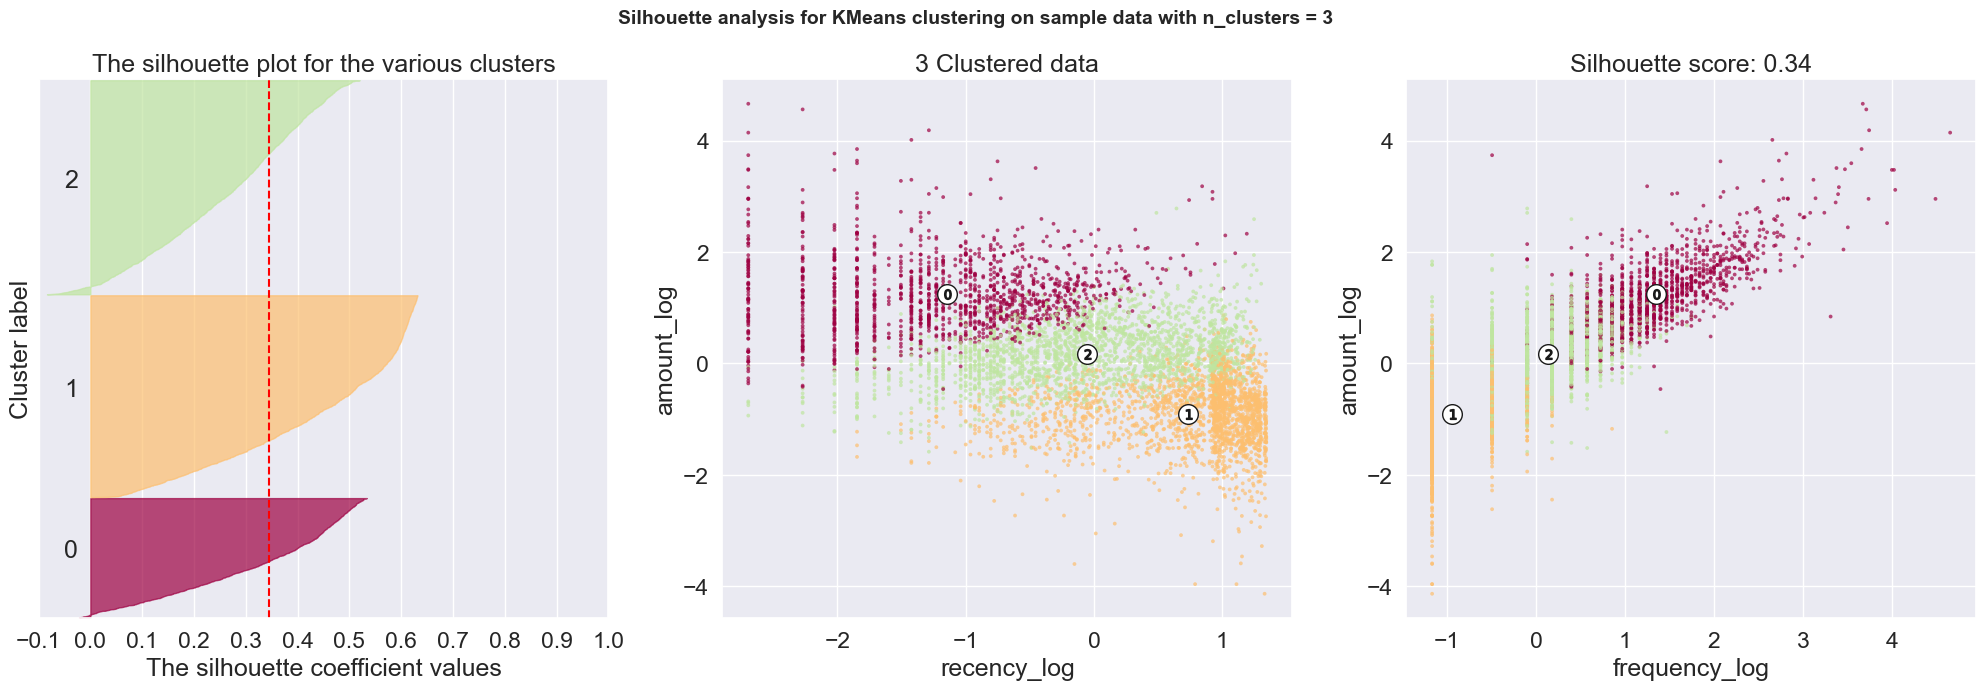

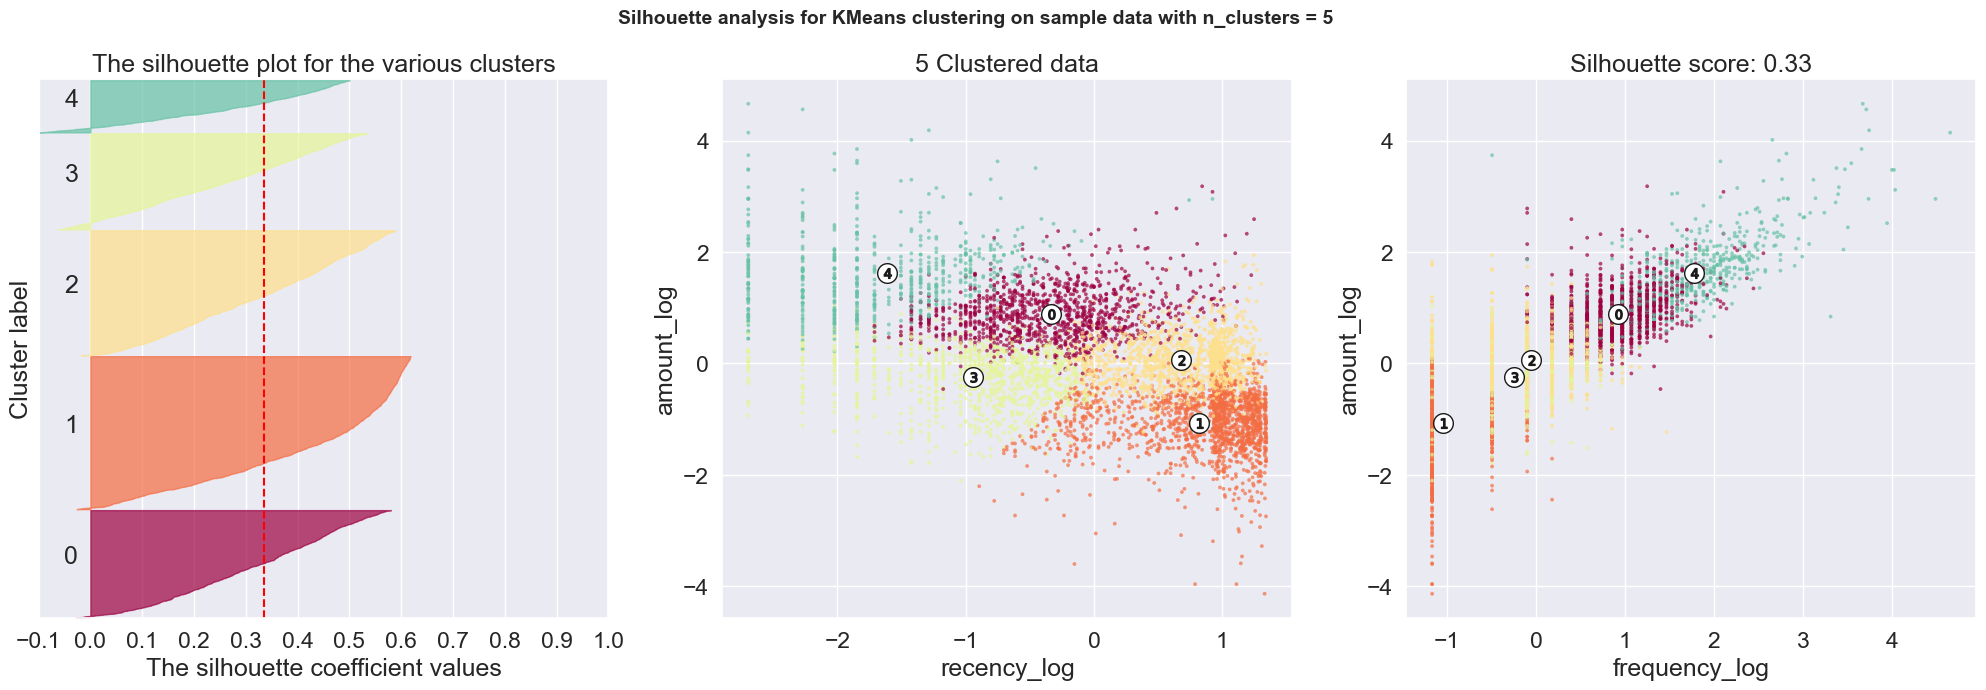

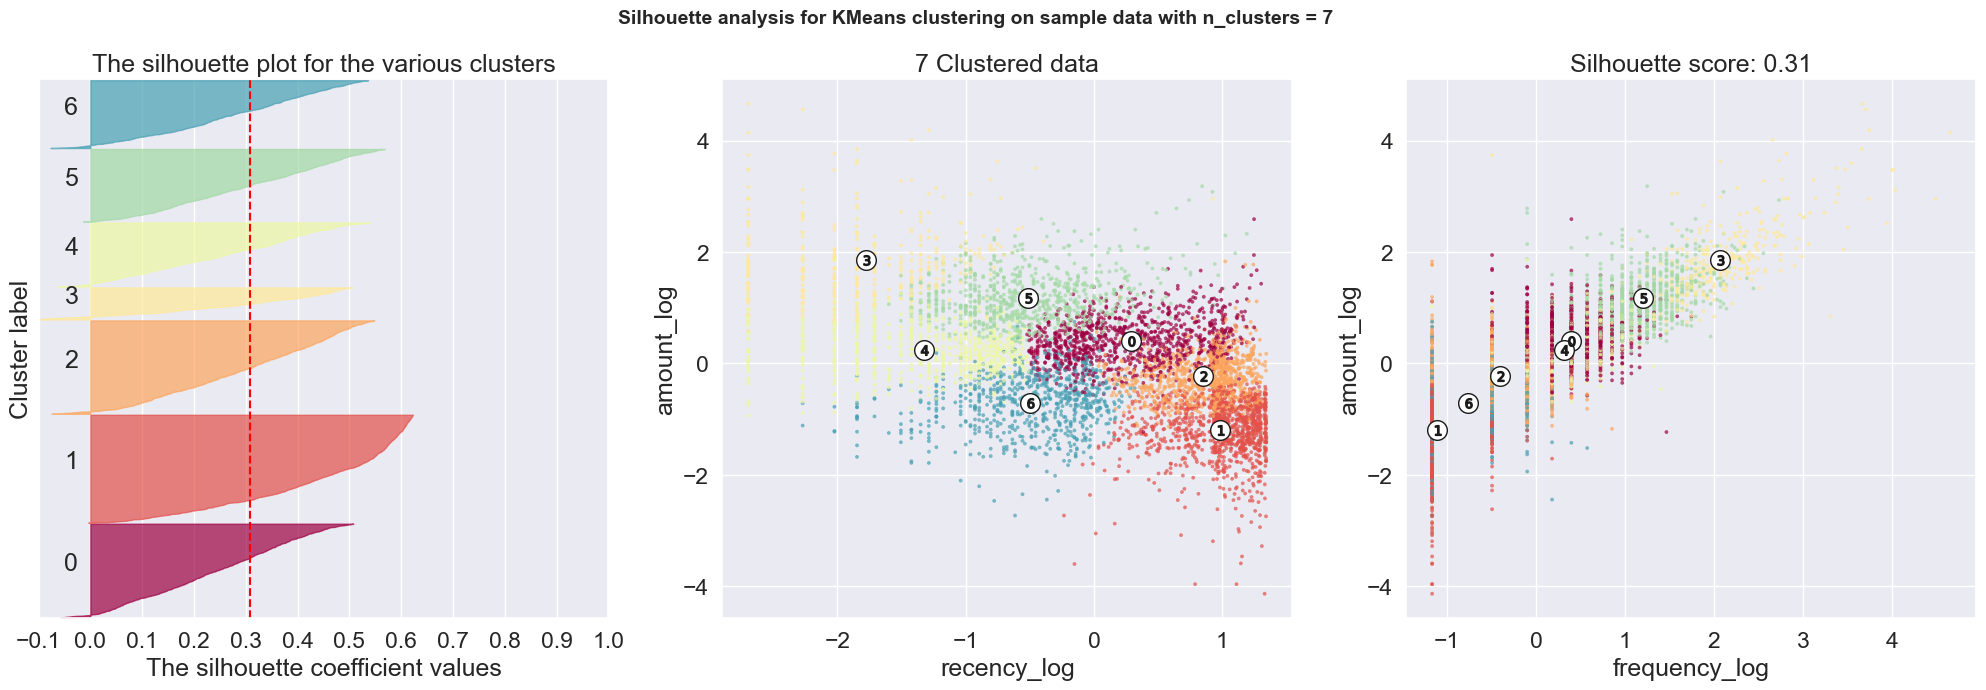

In [25]:
cluster_centers = dict()

for n_clusters in range(3,K_best+1,2):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(25, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10,max_iter=300, tol=1e-04, random_state=101)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X = X_scaled, labels = cluster_labels)
    cluster_centers.update({n_clusters :{'cluster_center':clusterer.cluster_centers_,
                                         'silhouette_score':silhouette_avg,
                                         'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X = X_scaled, labels = cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    colors = cm.Spectral(cluster_labels.astype(float) / n_clusters)
    
    centers = clusterer.cluster_centers_
    y = 0
    x = 1
    ax2.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax2.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax2.set_title("{} Clustered data".format(n_clusters))
    ax2.set_xlabel(feature_vector[x])
    ax2.set_ylabel(feature_vector[y])

    x = 2
    ax3.scatter(X_scaled[:, x], X_scaled[:, y], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')   
    ax3.scatter(centers[:, x], centers[:, y], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax3.scatter(c[x], c[y], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    ax3.set_title("Silhouette score: {:1.2f}".format(cluster_centers[n_clusters]['silhouette_score']))
    ax3.set_xlabel(feature_vector[x])
    ax3.set_ylabel(feature_vector[y])
    
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()

When we look at the results of the clustering process, we can infer some interesting insights:

- First notice that all K clusters options is valid, because they don't have presence of clusters with below average silhouette scores. 
- In the other hand, all options had a some wide fluctuations in the size of the silhouette plots. 

So, the best choice may lie on the option that gives us a simpler business explanation and at the same time target customers in focus groups with sizes closer to the desired. 

#### Clusters Center:
Let's look at the cluster center values after returning them to normal values from the log and scaled version. 

In [26]:
features = ['amount',  'recency',  'frequency']
for i in range(3,K_best+1,2):
    print("for {} clusters the silhouette score is {:1.2f}".format(i, cluster_centers[i]['silhouette_score']))
    print("Centers of each cluster:")
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=features))
    print('-'*50)

for 3 clusters the silhouette score is 0.34
Centers of each cluster:
        amount     recency  frequency
0  5283.040236   12.621855  13.354489
1   259.789442  271.895983   1.258509
2  1171.330513   75.201340   3.835695
--------------------------------------------------
for 5 clusters the silhouette score is 0.33
Centers of each cluster:
        amount     recency  frequency
0  3184.377106   47.255069   8.604195
1   211.968212  315.144996   1.133319
2  1003.783776  247.655703   3.140115
3   661.198652   17.612832   2.586851
4  8848.765754    5.848280  20.534748
--------------------------------------------------
for 7 clusters the silhouette score is 0.31
Centers of each cluster:
         amount     recency  frequency
0   1633.703232  131.094709   4.989394
1    177.317222  411.624649   1.063208
2    675.466483  329.988385   2.198532
3  12170.823370    4.458086  27.745369
4   1302.817656    9.365983   4.570572
5   4732.128781   35.405066  11.464285
6    350.001747   36.224182   1.506608

#### Clusters Insights:

With the plots and the center in the correct units, let's see some insights by each clusters groups:

***In the three-cluster:***
- The tree clusters appears have a good stark differences in the Monetary value of the customer, we will confirm this by a box plot.
- Cluster 1 is the cluster of high value customer who shops frequently and is certainly an important segment for each business.
- In the similar way we obtain customer groups with low and medium spends in clusters with labels 0 and 2, respectively.
- Frequency and Recency correlate perfectly to the Monetary value based on the trend (High Monetary-Low Recency-High Frequency).

***In the five-cluster:***
- Note that clusters 0 and 1 are very similar to their cluster in the configuration with only 3 clusters.
- The cluster 1 appears more robust on the affirmation of those who shop often and with high amount.
- The cluster 2 are those who have a decent spend but are not as frequent as the cluster 1
- The cluster 4 purchases medium amounts, with a relatively low frequency and not very recent
- The cluster 3 makes low-cost purchases, with a relatively low frequency, but above 1, and made their last purchase more recently. This group of customers probably response to price discounts and can be subject to loyalty promotions to try increase the medium-ticket, strategy that can be better defined when we analyzing the market basket. 
- The silhouette score matrix says that the  five cluster segments are less optimal then the three cluster segments. 

***In the seven-cluster:***
- Definitely cluster 6 defines those who shop often and with high amount.
- Clusters 1 and 5 show good spending and good frequency, only deferring in how recent were their last purchases, where 5 is older, which suggests an active action to sell to group 5 as soon as possible and another to 1 seeking to raise its frequency.
- Cluster 0 presents the fourth best purchase and a reasonable frequency, but this is a long time without buying. This group should be sensible to promotions and activations, so that they do not get lost and make their next purchase.
- Cluster 5 is similar to 0, but has made its purchases more recently and has a slightly better periodicity. Then actions must be taken to raise their frequency and reduce the chances of them migrating to cluster 0 by staying longer without purchasing products.

#### Drill Down Clusters:

To further drill down on this point and find out the quality of these difference, we can label our data with the corresponding cluster label and then visualize these differences. The following code will extract the clustering label and attach it with our customer summary dataset.

CustomerID  recency  frequency    amount  recency_log  frequency_log  \
0       12346    326.0         12  77556.46     5.786897       2.484907   
1       12347      2.0          8   5633.32     0.693147       2.079442   
2       12348     75.0          5   2019.40     4.317488       1.609438   
3       12349     19.0          4   4428.69     2.944439       1.386294   
4       12350    310.0          1    334.40     5.736572       0.000000   

   amount_log  clusters_3  clusters_5  clusters_7  
0   11.258761           0           0           5  
1    8.636454           0           4           3  
2    7.610556           2           0           0  
3    8.395859           0           0           4  
4    5.812338           1           1           1

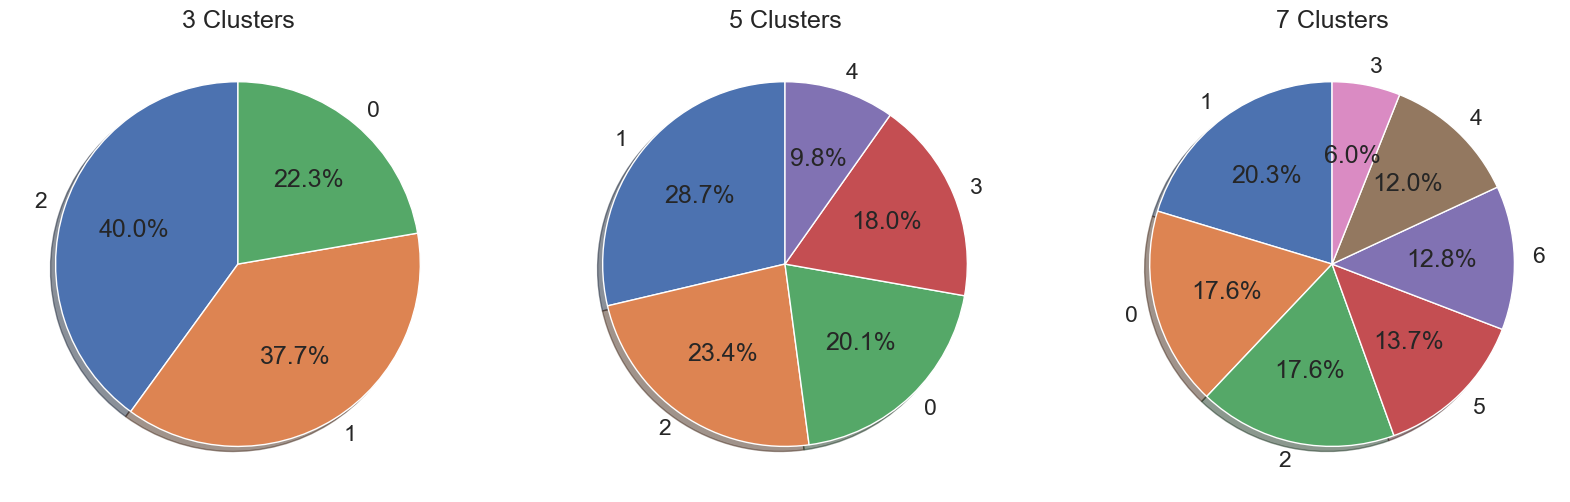

In [27]:
customer_history_df['clusters_3'] = cluster_centers[3]['labels'] 
customer_history_df['clusters_5'] = cluster_centers[5]['labels']
customer_history_df['clusters_7'] = cluster_centers[7]['labels']
display(customer_history_df.head())

fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
market = customer_history_df.clusters_3.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('3 Clusters')
f1 = fig.add_subplot(132)
market = customer_history_df.clusters_5.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('5 Clusters')
f1 = fig.add_subplot(133)
market = customer_history_df.clusters_7.value_counts()
g = plt.pie(market, labels=market.index, autopct='%1.1f%%', shadow=True, startangle=90)
plt.title('7 Clusters')
plt.show()

Once we have the labels assigned to each of the customers, our task is simple. Now we want to find out how the summary of customer in each group is varying. If we can visualize that information we will able to find out the differences in the clusters of customers and we can modify our strategy on the basis of those differences.

The following code leverages plotly and will take the cluster labels we got for each configurations clusters and create boxplots. Plotly enables us to interact with the plots to see the central tendency values in each boxplot in the notebook. Note that we want to avoid the extremely high outlier values of each group, as they will interfere in making a good observation around the central tendencies of each cluster. Since we have only positive values, we will restrict the data such that only data points which are less than 0.95th percentile of the cluster is used. This will give us good information about the majority of the users in that cluster segment.

I've used these charts to review my previously stated insights, but follow the same for you to explore:

In [28]:
features

['amount', 'recency', 'frequency']

In [29]:
x_data = ['Cluster 0', 'Cluster 1','Cluster 2','Cluster 3','Cluster 4', 'Cluster 5', 'Cluster 6']
colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 'rgba(255, 65, 54, 0.5)', 
          'rgba(22, 80, 57, 0.5)', 'rgba(127, 65, 14, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
cutoff_quantile = 95

for n_clusters in range(3,K_best+1,2):
    cl = 'clusters_' + str(n_clusters)
    for fild in range(0, 3):
        field_to_plot = features[fild]        
        y_data = list()
        ymax = 0
        for i in np.arange(0,n_clusters):
            y0 = customer_history_df[customer_history_df[cl]==i][field_to_plot].values
            y0 = y0[y0<np.percentile(y0, cutoff_quantile)]
            if ymax < max(y0): ymax = max(y0)
            y_data.insert(i, y0)

        traces = []

        for xd, yd, cls in zip(x_data[:n_clusters], y_data, colors[:n_clusters]):
            traces.append(go.Box(y=yd, name=xd, boxpoints=False, jitter=0.5, whiskerwidth=0.2, fillcolor=cls,
                                 marker=dict( size=1, ), line=dict(width=1), ))

        layout = go.Layout(
            title='Difference in {} with {} Clusters and {:1.2f} Score'.\
            format(field_to_plot, n_clusters, cluster_centers[n_clusters]['silhouette_score']),
            yaxis=dict(autorange=True, showgrid=True, zeroline=True,
                dtick = int(ymax/10),
                gridcolor='black', gridwidth=0.1, zerolinecolor='rgb(255, 255, 255)', zerolinewidth=2, ),
            margin=dict(l=40, r=30, b=50, t=50, ),
            paper_bgcolor='white',
            plot_bgcolor='white',
            showlegend=False
        )

        fig = go.Figure(data=traces, layout=layout)
        py.offline.iplot(fig)

### Next Steps in the Segmentation:

To enhance discovery and can further improve the quality of clustering by adding relevant features, other customer information and purchases details may be included in this dataset. 

For example, but not limited to:
- New indicators, such as customer relationship time, based on the date of your first purchase of the client
- whether the customer is from abroad or not
- some group or category of product to be obtained through the SKUs
- External data vendors and use it, and so on.

Another dimension to explore can be trying out different algorithms for performing the segmentation for instance hierarchical clustering, which we explored in some of the earlier chapters. A good segmentation process will encompass all these avenues to arrive at optimal segments that provide valuable insight.

## Cross Selling

The cross selling is the ability to sell more products to a customer by analyzing the customer's shopping trends as well as general shopping trends and patterns which are in common with the customer's shopping patterns. More often than not, these recommended products would be very appealing. The retailer will often offer you a bundle of products with some attractive offer and it is highly likely that we will end up buying the bundled products instead of just the original item. 

So, we research the customer transactions and find out potential additions to the customer's original needs and offer it to the customer as a suggestion in the hope and intent that they buy them benefiting both the customer as well as the retail establishment.

In this section, we explore association rule-mining, a powerful technique that can be used for cross selling, then we apply the concept of market basket analysis to our retail transactions dataset.

### Market Basket Analysis with Association Rule-Mining

The whole concept of association rule-mining is based on the concept that customer purchase behavior has a pattern which can be exploited for selling more items to the customer in the future.

Association rule learning is a rule-based machine learning method for discovering interesting relations between variables in large databases. It is intended to identify strong rules discovered in databases using some measures of interestingness. This rule-based approach also generates new rules as it analyzes more data. The ultimate goal, assuming a large enough dataset, is to help a machine mimic the human brain's feature extraction and abstract association capabilities from new uncategorized data.

An association rule usually has the structure like below:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/3141048979b977982202dbf7a80596f8a6b1177e)
This rule can be read in the obvious manner that when the customer bought items on the left of the rule he is likely to buy the item on the right. Following are some vital concepts pertaining to association rule-mining.
- **Itemset**: Is just a collection of one or more items that occur together in a transaction. For example, here {milk, bread} is example of an itemset.
- **Support**: is defined as number of times an itemset appears in the dataset. The support of ***X*** with respect to ***T*** is defined as the proportion of transactions ***t*** in the dataset which contains the itemset ***X***. Mathematically it is defined as:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/1c6acacd3b17051205704b5d323c83fc737e5db1)
- **Confidence**: Confidence is an indication of how often the rule has been found to be true. It is a measure of the times the number of times a rule is found to exist in the dataset. For a rule which states { beer -> diaper } the confidence is mathematically defined as:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/90324dedc399441696116eed3658fd17c5da4329)
- **Lift**: Lift of the rule is defined as the ratio of observed support to the support expected in the case the elements of the rule were independent. For the previous set of transactions if the rule is defined as { X -> Y }, then the lift of the rule is defined as:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/c392e3111167b60687405dfdc7ed55f22409f4c5)
    - If the rule had a lift of 1, it would imply that the probability of occurrence of the antecedent and that of the consequent are independent of each other. When two events are independent of each other, no rule can be drawn involving those two events.
    - If the lift is > 1, that lets us know the degree to which those two occurrences are dependent on one another, and makes those rules potentially useful for predicting the consequent in future data sets.
    - If the lift is < 1, that lets us know the items are substitute to each other. This means that presence of one item has negative effect on presence of other item and vice versa.
- **Frequent itemset**: Frequent itemsets are itemsets whose support is greater than a user defined support threshold.
- **Conviction**: Is the ratio of the expected frequency that item X occurs without a item Y (that is to say, the frequency that the rule makes an incorrect prediction) if X and Y were independent divided by the observed frequency of incorrect predictions. The conviction of a rule is defined as:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/4c2228820d6a8cb5a84bd059d53764a6b9280386)

#### Algorithms:

Some well-known algorithms are Apriori, Eclat and FP-Growth, but they only do half the job, since they are algorithms for mining frequent itemsets. Another step needs to be done after to generate rules from frequent itemsets found in a database.

The major bottleneck in any association rule-mining algorithm is the generation of frequent itemsets. If the transaction
dataset is having k unique products, then potentially we have 2<sup>k</sup> possible itemsets. 

##### Apriori
Apriori uses a breadth-first search strategy to count the support of itemsets and uses a candidate generation function which exploits the downward closure property of support. So, the algorithm will first generate these itemsets and then proceed to finding the frequent itemsets.  For around 100 unique products the possible number of itemsets is huge, and shows up that the Apriori algorithm prohibitively computationally expensive.

##### Eclat algorithm
Eclat is a depth-first search algorithm based on set intersection. It is suitable for both sequential as well as parallel execution with locality-enhancing properties.

##### FP Growth
FP stands for frequent pattern. The FP growth algorithm is superior to Apriori algorithm as it doesn't need to generate all the candidate itemsets. The FP growth algorithm uses a divide-and-conquer strategy and leverages a special data structure called the FP-tree, to find frequent itemsets without generating all itemsets. The core steps of the algorithm are as follows:
1. In the first pass, the algorithm take in the transactional database and counts occurrence of items (attribute-value pairs) in the dataset, and stores them to 'header table'. 
2. In the second pass, it builds the FP-tree structure by inserting instances to represent frequent itemsets. Items in each instance have to be sorted by descending order of their frequency in the dataset, so that the tree can be processed quickly. Items in each instance that do not meet minimum coverage threshold are discarded. If many instances share most frequent items, FP-tree provides high compression close to tree root.
3. Divide this compressed representation into multiple conditional datasets such that each one is associated with a frequent pattern.
4. Mine for patterns in each such dataset so that shorter patterns can be recursively concatenated to longer patterns, hence making it more efficient.

Recursive processing of this compressed version of main dataset grows large item sets directly, instead of generating candidate items and testing them against the entire database. Growth starts from the bottom of the header table (having longest branches), by finding all instances matching given condition. New tree is created, with counts projected from the original tree corresponding to the set of instances that are conditional on the attribute, with each node getting sum of its children counts. Recursive growth ends when no individual items conditional on the attribute meet minimum support threshold, and processing continues on the remaining header items of the original FP-tree.

Once the recursive process has completed, all large item sets with minimum coverage have been found, and association rule creation begins.

#### Build Transaction Dataset
In order to perform our data in these algorithms, we must first turn them into a sales event table where each product sold will be represented by a column, having its value 1 for when it was sold in that event or zero when not. This will generate a sparse table

In [30]:
items = list(cs_df.Description.unique())
grouped = cs_df.groupby('Invoice')
transaction_level = grouped.aggregate(lambda x: tuple(x)).reset_index()[['Invoice','Description']]
transaction_dict = {item:0 for item in items}
output_dict = dict()
temp = dict()
for rec in transaction_level.to_dict('records'):
    invoice_num = rec['Invoice']
    items_list = rec['Description']
    transaction_dict = {item:0 for item in items}
    transaction_dict.update({item:1 for item in items if item in items_list})
    temp.update({invoice_num:transaction_dict})

new = [v for k,v in temp.items()]
transaction_df = pd.DataFrame(new)

In [31]:
transaction_df

15CM CHRISTMAS GLASS BALL 20 LIGHTS  PINK CHERRY LIGHTS  \
0                                        1                   1   
1                                        0                   0   
2                                        0                   0   
3                                        0                   0   
4                                        0                   0   
...                                    ...                 ...   
36964                                    0                   0   
36965                                    0                   0   
36966                                    0                   0   
36967                                    0                   0   
36968                                    0                   0   

        WHITE CHERRY LIGHTS  RECORD FRAME 7" SINGLE SIZE   \
0                         1                             1   
1                         0                             0   
2                         0                             0   
3                         0                             0   
4                         0                             0   
...                     ...                           ...   
36964                     0                             0   
36965                     0                             0   
36966                     0                             0   
36967                     0                             0   
36968                     0                             0   

       STRAWBERRY CERAMIC TRINKET BOX  PINK DOUGHNUT TRINKET POT   \
0                                   1                           1   
1                                   0                           0   
2                                   0                           0   
3                                   0                           0   
4                                   0                           0   
...                               ...                         ...   
36964                               0                           0   
36965                               0                           0   
36966                               0                           0   
36967                               0                           0   
36968                               0                           0   

       SAVE THE PLANET MUG  DOORMAT FANCY FONT HOME SWEET HOME  \
0                        1                                   1   
1                        0                                   0   
2                        0                                   0   
3                        0                                   0   
4                        0                                   0   
...                    ...                                 ...   
36964                    0                                   0   
36965                    0                                   0   
36966                    0                                   0   
36967                    0                                   0   
36968                    0                                   0   

       ILLUSTRATED CAT BOWL   DOG BOWL CHASING BALL DESIGN  ...  \
0                          0                             0  ...   
1                          1                             1  ...   
2                          0                             0  ...   
3                          0                             0  ...   
4                          0                             0  ...   
...                      ...                           ...  ...   
36964                      0                             0  ...   
36965                      0                             0  ...   
36966                      0                             0  ...   
36967                      0                             0  ...   
36968                      0                             0  ...   

       BICYCLE PUNCTURE REPAIR KIT   CLASSIC BICYCLE C

#### Prune Dataset for frequently purchased items
We saw in the earlier on EDA how only a handful of items are responsible for bulk of our sales so we want to prune our dataset to reflect this information. For this we have created a function prune_dataset below, which will help us reduce the size of our dataset based on our requirements. The function can be used for performing three types of pruning:
- Pruning based on percentage of total sales: The parameter total_sales_perc will help us select the number of items that will explain the required percentage of sales. The default value is 50% or 0.5.
- Pruning based on ranks of items: Another way to perform the pruning is to specify the starting and the ending rank of the items for which we want to prune our dataset.
- Pruning based on list of features passed to the parameter TopCols. 

By default, we will only look for transactions which have at least two items, as transactions with only one item are counter to the whole concept of association rule-mining. 

In [32]:
def prune_dataset(input_df, length_trans = 2, total_sales_perc = 0.5, 
                  start_item = None, end_item = None, TopCols = None):
    if 'total_items' in input_df.columns:
        del(input_df['total_items'])
    item_count = input_df.sum().sort_values(ascending = False).reset_index()
    total_items = sum(input_df.sum().sort_values(ascending = False))
    item_count.rename(columns={item_count.columns[0]:'item_name',
                               item_count.columns[1]:'item_count'}, inplace=True)
    if TopCols: 
        input_df['total_items'] = input_df[TopCols].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[TopCols], item_count[item_count.item_name.isin(TopCols)]
    elif end_item > start_item:
        selected_items = list(item_count[start_item:end_item].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items],item_count[start_item:end_item]
    else:
        item_count['item_perc'] = item_count['item_count']/total_items
        item_count['total_perc'] = item_count.item_perc.cumsum()
        selected_items = list(item_count[item_count.total_perc < total_sales_perc].item_name)
        input_df['total_items'] = input_df[selected_items].sum(axis = 1)
        input_df = input_df[input_df.total_items >= length_trans]
        del(input_df['total_items'])
        return input_df[selected_items], item_count[item_count.total_perc < total_sales_perc]

We use the second option of pruning, by the Top 15th products in sales events.

In [33]:
output_df, item_counts = prune_dataset(input_df=transaction_df, length_trans=2,start_item = 0, end_item = 15)
print('Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): {:.2f}'.format(AmoutSum[Top15ev].sum()))
print('Number of Sales Events:', output_df.shape[0])
print('Number of Products:', output_df.shape[1])

item_counts

Total of Sales Amount by the Top 15 Products in Sales Events (Invoice): 1325539.86
Number of Sales Events: 8888
Number of Products: 15


item_name  item_count
0   WHITE HANGING HEART T-LIGHT HOLDER        4895
1             REGENCY CAKESTAND 3 TIER        3317
2              JUMBO BAG RED RETROSPOT        3260
3        ASSORTED COLOUR BIRD ORNAMENT        2652
4              LUNCH BAG RED RETROSPOT        2579
5      PACK OF 72 RETROSPOT CAKE CASES        2508
6                        PARTY BUNTING        2077
7              LUNCH BAG SUKI  DESIGN         2004
8              LUNCH BAG  BLACK SKULL.        1997
9           LUNCH BAG SPACEBOY DESIGN         1919
10      STRAWBERRY CERAMIC TRINKET BOX        1893
11        REX CASH+CARRY JUMBO SHOPPER        1857
12             LUNCH BAG PINK POLKADOT        1845
13    RETROSPOT TEA SET CERAMIC 11 PC         1838
14            HOME BUILDING BLOCK WORD        1831

In [34]:
1325539.86/cs_df.amount.sum()

0.07470595715756743

So we find out that we have 15 items responsible for 7.47% of sales amount and close to 5% of the events result in 8888 transactions that have those items along with other items. The next step is to convert this selected data into the required table data structure.

#### Association Rule Mining with FP Growth

##### Orange Table Data Structure
Since we are using the Orage framework we still have to convert it to the Table data structure by providing the metadata about our columns. We need to define the domain for each of our variables. The domain means the possible set of values that each of our variables can use. This information will be stored as metadata and will be used in later transformation of the data. As our columns are only having binary values,we can easily create the domain by using this information. 

In [35]:
input_assoc_rules = output_df
# Defined the data domain by specifying each variable as a DiscreteVariable having values as (0, 1)
domain_transac = Domain([DiscreteVariable.make(name=item,values=['0', '1']) \
                         for item in input_assoc_rules.columns])

# Then using this domain, we created our Table structure for our data
data_tran = Orange.data.Table.from_numpy(domain=domain_transac,  
                                         X=input_assoc_rules.values,Y= None)

# Coding our input so that the entire domain is represented as binary variables
data_tran_en, mapping = OneHot.encode(data_tran, include_class=True)

##### Creating our rules
We need to specify two pieces of information for generating our rules: support and confidence. An important piece of information is to start with a higher support, as lower support will mean a higher number of frequent itemsets and hence a longer execution time. We will specify a min support of 0.01 and see the number of frequent itemsets that we get before we specify confidence and generate our rules.

In [36]:
support = 0.01
print("num of required transactions = ", int(input_assoc_rules.shape[0]*support))
num_trans = input_assoc_rules.shape[0]*support
itemsets = dict(frequent_itemsets(data_tran_en, support))
print('Items Set Size:', len(itemsets))

num of required transactions =  88
Items Set Size: 666575


So we get a whopping 666575 itemsets for only 15 itenms and a support of only 1%! This will increase exponentially if we decrease the support or if we increase the number of items in our dataset. The next step is specifying a confidence value and generating our rules. The following code snippet will perform rule generation and decoding of rules, and then compile it all in a neat dataframe that we can use for further analysis.

In [37]:
confidence = 0.6
rules_df = pd.DataFrame()
if len(itemsets) < 1000000: 
    rules = [(P, Q, supp, conf)
    for P, Q, supp, conf in association_rules(itemsets, confidence)
       if len(Q) == 1 ]

    names = {item: '{}={}'.format(var.name, val)
        for item, var, val in OneHot.decode(mapping, data_tran, mapping)}
    
    eligible_ante = [v for k,v in names.items() if v.endswith("1")]
    
    N = input_assoc_rules.shape[0]
    
    rule_stats = list(rules_stats(rules, itemsets, N))
    
    rule_list_df = []
    for ex_rule_frm_rule_stat in rule_stats:
        ante = ex_rule_frm_rule_stat[0]            
        cons = ex_rule_frm_rule_stat[1]
        named_cons = names[next(iter(cons))]
        if named_cons in eligible_ante:
            rule_lhs = [names[i][:-2] for i in ante if names[i] in eligible_ante]
            ante_rule = ', '.join(rule_lhs)
            if ante_rule and len(rule_lhs)>1 :
                rule_dict = {'support' : ex_rule_frm_rule_stat[2],
                             'confidence' : ex_rule_frm_rule_stat[3],
                             'coverage' : ex_rule_frm_rule_stat[4],
                             'strength' : ex_rule_frm_rule_stat[5],
                             'lift' : ex_rule_frm_rule_stat[6],
                             'leverage' : ex_rule_frm_rule_stat[7],
                             'antecedent': ante_rule,
                             'consequent':named_cons[:-2] }
                rule_list_df.append(rule_dict)
    rules_df = pd.DataFrame(rule_list_df)
    print("Raw rules data frame of {} rules generated".format(rules_df.shape[0]))
    if not rules_df.empty:
        pruned_rules_df = rules_df.groupby(['antecedent','consequent']).max().reset_index()
    else:
        print("Unable to generate any rule")

Raw rules data frame of 31609 rules generated


##### Explore The Association Rule Created

Let's see what we get in the first 5 rules with highest confidence:

In [38]:
dw = pd.options.display.max_colwidth
pd.options.display.max_colwidth = 100
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['confidence', 'support', 'lift'],
                                                   ascending=False)).head()

consequent  \
70   LUNCH BAG RED RETROSPOT   
77   LUNCH BAG RED RETROSPOT   
110  LUNCH BAG RED RETROSPOT   
130  LUNCH BAG RED RETROSPOT   
132  LUNCH BAG RED RETROSPOT   

                                                                                             antecedent  \
70   JUMBO BAG RED RETROSPOT, LUNCH BAG SUKI  DESIGN , LUNCH BAG  BLACK SKULL., LUNCH BAG PINK POLKADOT   
77   LUNCH BAG  BLACK SKULL., JUMBO BAG RED RETROSPOT, LUNCH BAG PINK POLKADOT, LUNCH BAG SUKI  DESIGN    
110                   LUNCH BAG PINK POLKADOT, PACK OF 72 RETROSPOT CAKE CASES, LUNCH BAG  BLACK SKULL.   
130                   PACK OF 72 RETROSPOT CAKE CASES, LUNCH BAG  BLACK SKULL., LUNCH BAG PINK POLKADOT   
132                PACK OF 72 RETROSPOT CAKE CASES, LUNCH BAG PINK POLKADOT, LUNCH BAG SPACEBOY DESIGN    

     support  confidence      lift  
70        90    0.841121  3.170436  
77       123    0.836735  3.153901  
110      109    0.807407  3.043358  
130       89    0.801802  3.022228  
132       89    0.801802  3.022228

Now, the first 5 higest support:

In [39]:
(rules_df[['consequent', 'antecedent', 'support','confidence','lift']].\
 groupby(['consequent', 'antecedent']).first()
                                      .reset_index()
                                      .sort_values(['support', 'confidence', 'lift'],
                                                   ascending=False)).head()

consequent  \
88   LUNCH BAG RED RETROSPOT   
100  LUNCH BAG RED RETROSPOT   
108  LUNCH BAG RED RETROSPOT   
123  LUNCH BAG RED RETROSPOT   
101  LUNCH BAG RED RETROSPOT   

                                                                    antecedent  \
88                            LUNCH BAG  BLACK SKULL., LUNCH BAG SUKI  DESIGN    
100                           LUNCH BAG PINK POLKADOT, LUNCH BAG  BLACK SKULL.   
108                           LUNCH BAG PINK POLKADOT, LUNCH BAG SUKI  DESIGN    
123                           LUNCH BAG SUKI  DESIGN , LUNCH BAG  BLACK SKULL.   
101  LUNCH BAG PINK POLKADOT, LUNCH BAG  BLACK SKULL., LUNCH BAG SUKI  DESIGN    

     support  confidence      lift  
88       431    0.602797  2.272121  
100      416    0.652038  2.457723  
108      382    0.664348  2.504124  
123      366    0.600985  2.265291  
101      340    0.750552  2.829052

Typically, a lift value of 1 indicates that the probability of occurrence of the antecedent and consequent together are independent of each other. Hence, the idea is to look for rules having a lift much greater than 1.  So, let's see how much rules has lift greater than 1, equal 1 and less than one:

In [40]:
rules_df.lift.apply(lambda x: 'Greater Than One' if x > 1 else 'One' \
                           if x == 0 else 'Less Than One').value_counts()

Greater Than One    31609
Name: lift, dtype: int64

So all rules are valid.

In [41]:
pd.options.display.max_colwidth = dw

#### Conclusion

As we have seen, the generation of rules is a very simple process, but very computationally expensive, since it grows exponentially with the increase of the set of items.

Overall, we seek the proper balance between support and confidence leading to a reasonable number of strong rules. 

In the other hand, if the goal is to identify rare but with high confidence patterns, we should proceed as previously, by establishing a low level of support and a higher level of confidence, which leads to a large number of rules.

With this in mind, the rules with low support and high confidence would then be our target for further study and than outlining of strategies to raise cross selling.